# Tissue dielectric calculations
*Author: Dr Vitas Anderson*

This is the second attempt to calculate $\epsilon_r$ and $\sigma$ values for the homogeneous phantom, using Hurt's 2/3 muscle estimates as the starting first guess values, with further iterative modifications after that.

Calculate tissue dielectric values using the Gabriel formulas published in:</br>
<font color='blue'>Gabriel, S. Lau, R.W. & Gabriel, C. (1996) **"The dielectric properties of biological tissues: III.
Parametric models for the dielectric spectrum of tissues"**, *Phys. Med. Biol.* 41 (1996) 2271–2293</font>

Tissue mass proportions were obtained from:</br>
<font color='blue'>Tahara, Y., Moji, K., Aoyagi, K., Tsunawake, N., Muraki, S., & Mascie-Taylor, C. G. N. (2002). **Age-related pattern of body density and body composition of Japanese men and women 18-59 years of age**. *American Journal of Human Biology*, 14(6).</font>

TARO intercomparison WBA SAR data was obtained from:</br>
<font color='blue'>Dimbylow, P. J., Hirata, A., & Nagaoka, T. (2008). **Intercomparison of whole-body averaged SAR in European and Japanese voxel phantoms**. Physics in Medicine and Biology, 53(20), 5883–5897.</font>

## Setup

In [207]:
import pandas as pd
import numpy as np
import altair as alt
print(f'Altair version: {alt.__version__}')
from scipy import interpolate
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sn
from icecream import ic
import os
from scipy.optimize import curve_fit
pd.set_option('display.max_rows', 100)

Altair version: 4.2.2


## Functions

In [139]:
def cce(w, e, tau, alpha):
    """Calculate the Cole-Cole equation for w (2.pi.f) and the dispersion parameters"""
    return e / (1 + (1j * w * tau)**(1-alpha))

def tissue_dielectric(p, fMHz, factor=1):
    """Calculate the Gabriel tissue dielectric values, er and sigma
       at fMHz frequency
       INPUTS:
         fMHz = frequency in MHz
         p = pandas array containing Gabriel tissue parameters
         factor = factor to multiply er and sigma (e.g. 2/3 for Hurt muscle)
       OUTPUTS:
         er = tissue relative permittivty
         sigma = tissue conductivity in units of S/m
       """
    
    # Permittivity of free space
    e0 = 8.85418782E-12  
    
    # Calculate the angular frequency, w'
    w = 2 * np.pi * (fMHz * 1e6)
    
    # Calculate the complex permitivity'
    ec = p.einf + cce(w,p.e1,p.tau1,p.alpha1) + \
                  cce(w,p.e2,p.tau2,p.alpha2) + \
                  cce(w,p.e3,p.tau3,p.alpha3) + \
                  cce(w,p.e4,p.tau4,p.alpha4) + \
                  p.sigma/(1j*w*e0)
    
    # Multiply ec by factor
    ec = ec * factor
    
    # Calculate permittivity and conductivity
    er = np.real(ec)
    sigma = -w * np.imag(ec) * e0
    
    return er, sigma

def make_quadfit(x,y):
    '''Returns a quadratic polynomial curve fitting function (quadfit)
       and the polynomial curvefit paramters (c) from 
       inputs arrays for x and y'''
    c = np.polyfit(x,y,2)
    quadfit = lambda x: c[0]*x**2 + c[1]*x + c[2]
    return quadfit, c

def loadSAR(taroSAR, FEKO_SEP_file):
    '''Creates a dataframe of the WBA SAR data from the FEKO SEP model 
       merged on frequency with the WBA SAR data for the TARO phantom
       in the Dimbylow study
       INPUTS:
         taroSAR = dataframe of TARO SAR data
         FEKO_SEP_file = file path for the SEP phantom WBA SAR data
       OUTPUT:
         dfSAR is a datframe of the merged TARO and SEP phantom data'''
    
    sepSAR = pd.read_csv(FEKO_SEP_file)
    if 'alpha' in sepSAR.columns:
        sepSAR = sepSAR.drop(columns='alpha')
    sepSAR.columns = ['fMHz','er','sigma','P','SARsep']
    sepSAR.SARsep = sepSAR.SARsep * 1E6  # convert to µW/kg

    dfSAR = sepSAR.merge(taroSAR,on='fMHz')
    dfSAR['SARratio'] = dfSAR.SARsep / dfSAR.SARtaro
    return dfSAR 

## Load TARO WBA SAR values
from the Dimbylow interlab comparison study

In [140]:
taro_file = "./data/TARO and HANAKO intercomparison data.xlsx"
taroSAR = pd.read_excel(taro_file, 'TARO',usecols=['MHz','HPA'])
taroSAR.rename(columns={'MHz':'fMHz','HPA':'SARtaro'},inplace=True)
taroSAR.head()

fMHz  SARtaro
0    30    15.96
1    40    32.20
2    50    56.93
3    60    82.78
4    65    89.44

## Load Gabriel tissue dielectric parameters

In [141]:
gtdp = pd.read_excel("./data/Gabriel tissue dielectric parameters.xlsx",index_col=0).T.astype(float)
gtdp

TISSUE                         einf   sigma    e1          tau1  alpha1  \
aorta                           4.0  0.2500  40.0  8.842000e-12    0.10   
bladder                         2.5  0.2000  16.0  8.842000e-12    0.10   
blood                           4.0  0.7000  56.0  8.377000e-12    0.10   
bone cancellous                 2.5  0.0700  18.0  1.326000e-11    0.22   
bone cortical                   2.5  0.0200  10.0  1.326000e-11    0.20   
bone marrow (infiltrated)       2.5  0.1000   9.0  1.447000e-11    0.20   
bone marrow (not infiltrated)   2.5  0.0005   3.0  7.958000e-12    0.20   
breast fat                      2.5  0.0100   3.0  1.768000e-11    0.10   
cartilage                       4.0  0.1500  38.0  1.326000e-11    0.15   
cerebellum                      4.0  0.0400  40.0  7.958000e-12    0.10   
cerebro spinal fluid            4.0  2.0000  65.0  7.958000e-12    0.10   
cervix                          4.0  0.3000  45.0  7.958000e-12    0.10   
colon                           4.0  0.0100  50.0  7.958000e-12    0.10   
cornea                          4.0  0.4000  48.0  7.958000e-12    0.10   
dura                            4.0  0.5000  40.0  7.958000e-12    0.15   
eye (sclera)                    4.0  0.5000  50.0  7.958000e-12    0.10   
fat (ave. infiltrated)          2.5  0.0350   9.0  7.958000e-12    0.20   
fat (not infiltrated)           2.5  0.0100   3.0  7.958000e-12    0.20   
gall bladder                    4.0  0.9000  55.0  7.579000e-12    0.05   
gall bladder bile               4.0  1.4000  66.0  7.579000e-12    0.05   
grey matter                     4.0  0.0200  45.0  7.958000e-12    0.10   
heart                           4.0  0.0500  50.0  7.958000e-12    0.10   
kidney                          4.0  0.0500  47.0  7.958000e-12    0.10   
lens (cortex)                   4.0  0.3000  42.0  7.958000e-12    0.10   
lens (nucleus)                  3.0  0.2000  32.0  8.842000e-12    0.10   
liver                           4.0  0.0200  39.0  8.842000e-12    0.10   
lung deflated                   4.0  0.2000  45.0  7.958000e-12    0.10   
lung inflated                   2.5  0.0300  18.0  7.958000e-12    0.10   
muscle                          4.0  0.2000  50.0  7.234000e-12    0.10   
nerve (spinal cord)             4.0  0.0060  26.0  7.958000e-12    0.10   
ovary                           4.0  0.3000  40.0  8.842000e-12    0.15   
skin - dry                      4.0  0.0002  32.0  7.234000e-12    0.00   
skin-wet                        4.0  0.0004  39.0  7.958000e-12    0.10   
small intestine                 4.0  0.5000  50.0  7.958000e-12    0.10   
spleen                          4.0  0.0300  48.0  7.958000e-12    0.10   
stomach                         4.0  0.5000  60.0  7.958000e-12    0.10   
tendon                          4.0  0.2500  42.0  1.224000e-11    0.10   
testis                          4.0  0.4000  55.0  7.958000e-12    0.10   
thyroid                         4.0  0.5000  55.0  7.958000e-12    0.10   
tongue                          4.0  0.2500  50.0  7.958000e-12    0.10   
trachea                         2.5  0.3000  38.0  7.958000e-12    0.10   
uterus                          4.0  0.2000  55.0  7.958000e-12    0.10   
vitreous humour                 4.0  1.5000  65.0  7.234000e-12    0.00   
white matter                    4.0  0.0200  32.0  7.958000e-12    0.10   

TISSUE                              e2          tau2  alpha2         e3  \
aorta                             50.0  3.183000e-09    0.10   100000.0   
bladder                          400.0  1.592000e-07    0.10   100000.0   
blood                           5200.0  1.326000e-07    0.10        0.0   
bone cancellous                  300.0  7.958000e-08    0.25    20000.0   
bone cortical                    180.0  7.958000e-08    0.20     5000.0   
bone marrow (infiltrated)         80.0  1.592000e-08    0.10    10000.0   
bone marrow (not infiltrated)     25.0  1.592000e-08    0.10     5000.0   
breast fat              

## Load SEP SAR values
The er and sigma dielectric values in Danie's .csv output files were rounded to just 3 significant figures which causes problems when combining all of the data in contour plots since the original unrounded er and sigma values were used in his clauculations. Therefore need to restore the er and sigma values to the in the output file to the unrounded values 

## Run 2: 2/3 muscle tissue dielectric values

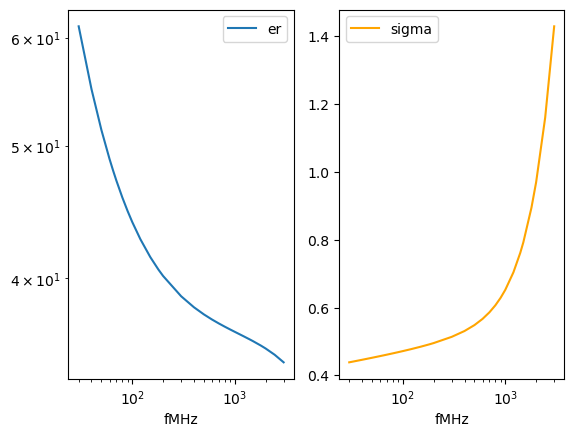

In [290]:
# Set Dimbylow cross lab validation frequencies
freqs = [30, 40, 50, 60, 65, 70, 80, 90, 100, 120, 150, 180, 200, 300, 
         400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1500, 1800, 
         2000, 2450, 3000]

# Calculate 2/3 tissue dielectric values for muscle
tlist = []
for fMHz in freqs:
    er, sigma = tissue_dielectric(gtdp.loc['muscle'], fMHz, factor=2/3)
    tlist.append([fMHz,er,sigma])

cols=('fMHz','er','sigma')
diel = pd.DataFrame(tlist,columns=cols)
diel.head()

fig, ax = plt.subplots(1,2,sharex=True)
diel.plot('fMHz','er',ax=ax[0])
diel.plot('fMHz','sigma',ax=ax[1],color='orange')
ax[0].set_yscale('log')
ax[1].set_xscale('log')


### Calculate $\epsilon_r$ and $\sigma$ investigation points

In [321]:
diel_list = []
fraclist = [0.6, 0.8, 1, 1.2, 1.4]
for row in diel.itertuples():
    er, sigma = row.er, row.sigma
    for frac_er in fraclist:
        for frac_sigma in fraclist:
            erf = row.er * frac_er
            sigmaf = row.sigma * frac_sigma
            diel_list.append([row.fMHz, erf, sigmaf])
            
diel_cols = ['fMHz','er','sigma']
diel2 = pd.DataFrame(diel_list, columns=cols).round(4)
diel2.to_excel('dielectric test values (run 2).xlsx',index=False)
diel2.to_csv('dielectric test values (run2).csv',index=False)
diel2.head(25)

fMHz       er   sigma
0     30  36.7241  0.2632
1     30  36.7241  0.3509
2     30  36.7241  0.4387
3     30  36.7241  0.5264
4     30  36.7241  0.6142
5     30  48.9654  0.2632
6     30  48.9654  0.3509
7     30  48.9654  0.4387
8     30  48.9654  0.5264
9     30  48.9654  0.6142
10    30  61.2068  0.2632
11    30  61.2068  0.3509
12    30  61.2068  0.4387
13    30  61.2068  0.5264
14    30  61.2068  0.6142
15    30  73.4482  0.2632
16    30  73.4482  0.3509
17    30  73.4482  0.4387
18    30  73.4482  0.5264
19    30  73.4482  0.6142
20    30  85.6895  0.2632
21    30  85.6895  0.3509
22    30  85.6895  0.4387
23    30  85.6895  0.5264
24    30  85.6895  0.6142

### Load WBA SAR data (µW/kg) from TARO intercomparison study and Danie's FEKO SEP phantom

In [172]:
FEKO_SEP_file_2 = './data/results_human-phantom-height1.72m.csv'
dfSAR2 = loadSAR(taroSAR, FEKO_SEP_file_2)
dfSAR2.head(25)

fMHz       er   sigma         P  SARsep  SARtaro  SARratio
0   30.0  36.7241  0.2632  0.001300  21.408    15.96  1.341353
1   30.0  36.7241  0.3509  0.001159  19.086    15.96  1.195865
2   30.0  36.7241  0.4387  0.001026  16.900    15.96  1.058897
3   30.0  36.7241  0.5264  0.000915  15.063    15.96  0.943797
4   30.0  36.7241  0.6142  0.000823  13.555    15.96  0.849311
5   30.0  48.9654  0.2632  0.001213  19.970    15.96  1.251253
6   30.0  48.9654  0.3509  0.001106  18.217    15.96  1.141416
7   30.0  48.9654  0.4387  0.000993  16.352    15.96  1.024561
8   30.0  48.9654  0.5264  0.000893  14.703    15.96  0.921241
9   30.0  48.9654  0.6142  0.000808  13.308    15.96  0.833835
10  30.0  61.2068  0.2632  0.001129  18.592    15.96  1.164912
11  30.0  61.2068  0.3509  0.001054  17.348    15.96  1.086967
12  30.0  61.2068  0.4387  0.000959  15.791    15.96  0.989411
13  30.0  61.2068  0.5264  0.000870  14.327    15.96  0.897682
14  30.0  61.2068  0.6142  0.000793  13.049    15.96  0.817607
15  30.0  73.4482  0.2632  0.001050  17.288    15.96  1.083208
16  30.0  73.4482  0.3509  0.001002  16.490    15.96  1.033208
17  30.0  73.4482  0.4387  0.000925  15.223    15.96  0.953822
18  30.0  73.4482  0.5264  0.000847  13.941    15.96  0.873496
19  30.0  73.4482  0.6142  0.000776  12.779    15.96  0.800689
20  30.0  85.6895  0.2632  0.000976  16.066    15.96  1.006642
21  30.0  85.6895  0.3509  0.000951  15.652    15.96  0.980702
22  30.0  85.6895  0.4387  0.000890  14.653    15.96  0.918108
23  30.0  85.6895  0.5264  0.000823  13.547    15.96  0.848810
24  30.0  85.6895  0.6142  0.000759  12.500    15.96  0.783208

### Plot the data

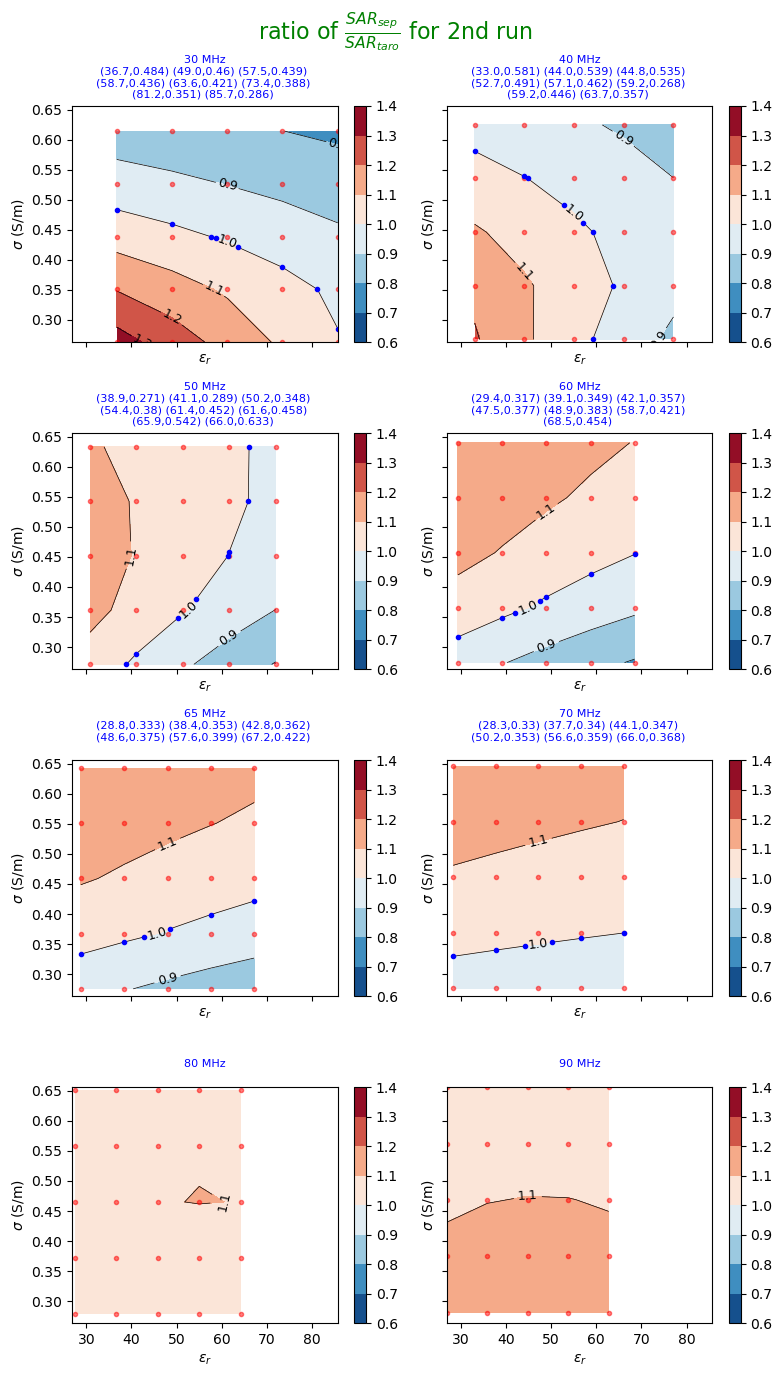

In [150]:
fig, axes = plt.subplots(4,2,figsize=(8,14),sharex=True,sharey=True)
axes = axes.flatten()
levels = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
ixlev1 = levels.index(1)
coords = []

for i, (fMHz, g) in enumerate(dfSAR2.groupby('fMHz')):
    if fMHz < 100:
        # draw contour plot for each fMHz
        er = g.er.values.reshape(5,5)
        sigma = g.sigma.values.reshape(5,5)
        SARratio = g.SARratio.values.reshape(5,5)
        CS = axes[i].contour(er,sigma,SARratio,levels=levels,
                             linewidths=0.5,colors='black')
        axes[i].clabel(CS, inline=True, fontsize=9)
        cntr2 = axes[i].contourf(er,sigma,SARratio,levels=levels,
                    cmap="RdBu_r")
        fig.colorbar(cntr2, ax=axes[i])
        axes[i].plot(er,sigma,'ro',ms=3,alpha=0.5)
        axes[i].set(xlabel=r'$\epsilon_r$',ylabel=r'$\sigma$ (S/m)')
        
        # Calculate and print the er/sigma coordinates for R=1
        coord = [[fMHz]+c for path in CS.collections[ixlev1].get_paths() for c in path.vertices.tolist()]
        coords = coords + coord
        coorddf = pd.DataFrame(coord, columns=['fMHz','er','sigma']).sort_values('er').reset_index()
        
        # Plot those R=1 coordinate points
        axes[i].plot(coorddf.er,coorddf.sigma,'bo',markersize=3)
        
        # list the R=1 coordinates in the title
        coordpairs = ''
        for ix, c in coorddf.iterrows():
            coordpairs += f'({round(c.er,1)},{round(c.sigma,3)}) '
            if (ix+1) % 3 == 0:
                coordpairs += '\n'
        title = f'{fMHz:g} MHz\n' + coordpairs
        axes[i].set_title(title, fontsize=8, color='blue')        

plt.suptitle(r'ratio of $\frac{SAR_{sep}}{SAR_{taro}}$ for 2nd run',
             color='green', fontsize=16)
fig.tight_layout()
# pd.DataFrame(coords, columns=['fMHz','er','sigma'])

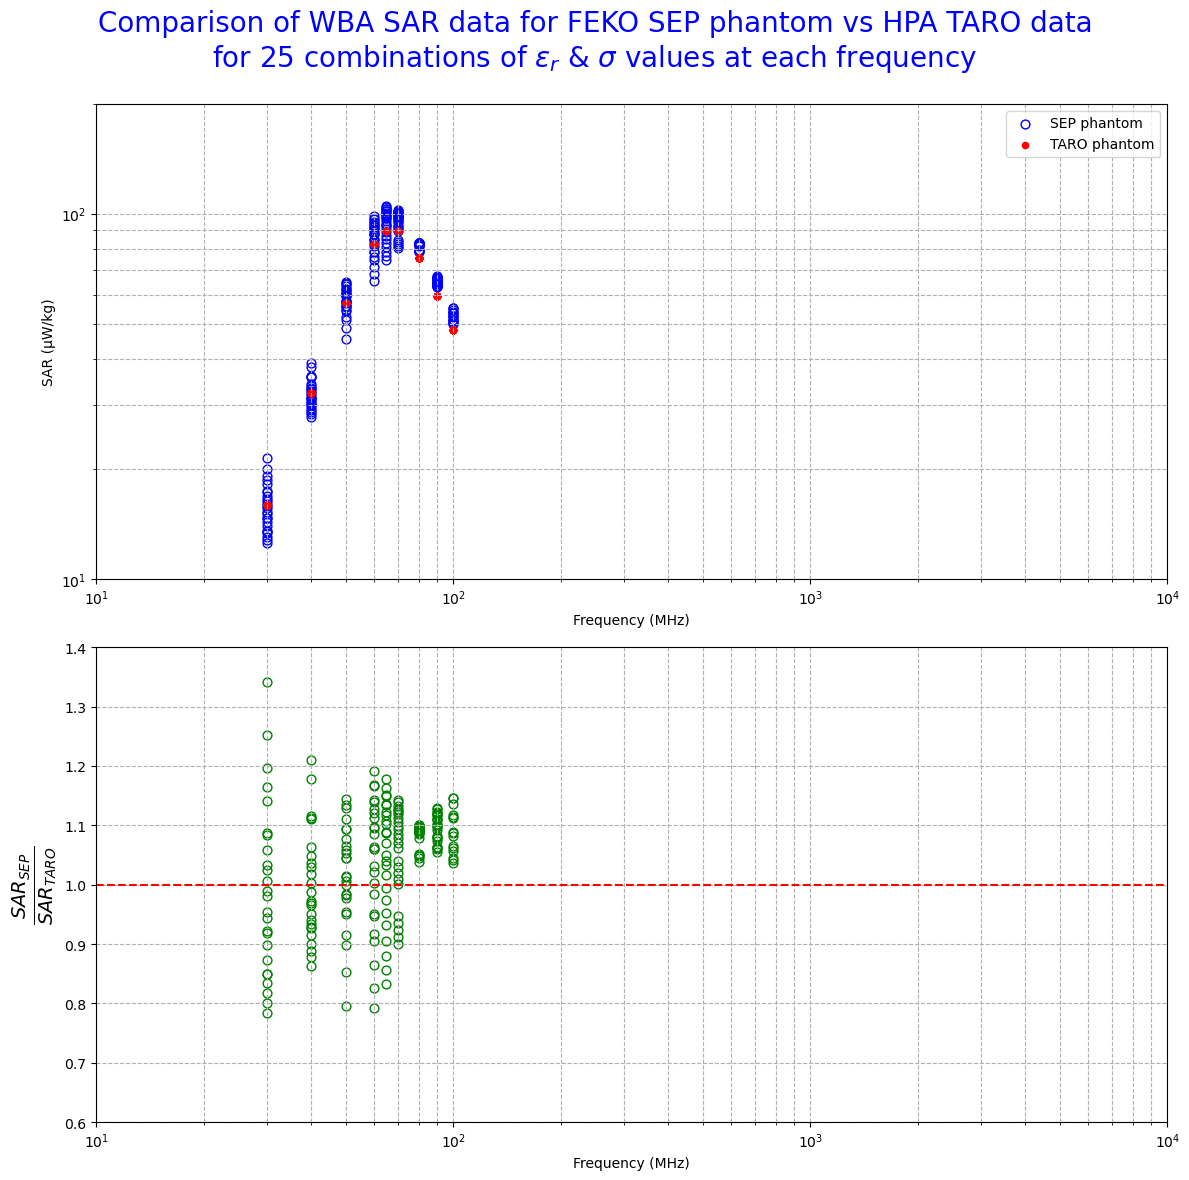

In [154]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(12,12))
plt.suptitle('Comparison of WBA SAR data for FEKO SEP phantom vs HPA TARO data\nfor 25 combinations of $\epsilon_r$ & $\sigma$ values at each frequency',
             color='blue',fontsize=20)

# top plot
dfSAR2.plot(x='fMHz',y='SARsep',kind='scatter',color="none", edgecolor="blue",s=40,
           ax=ax1,label='SEP phantom')
dfSAR2.plot(x='fMHz',y='SARtaro',kind='scatter',color='r',
           ax=ax1, label='TARO phantom')
ax1.set_ylim([10,200])
ax1.set_xlim([10,10_000])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('SAR (µW/kg)')
ax1.legend()
ax1.grid(True, which='both',ls='--')

# bottom plot
dfSAR2.plot(x='fMHz',y='SARratio',kind='scatter',color="none", 
            edgecolor="green",s=40, ax=ax2)
ax2.axhline(y=1, color='r', linestyle='--')
ax2.set_ylim([0.6,1.4])
ax2.set_xlim([10,10_000])
ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{SAR_{SEP}}{SAR_{TARO}}$', fontsize=20)
ax2.set_xlabel('Frequency (MHz)')
ax2.grid(True, which='both',ls='--')
fig.tight_layout(rect=(0,0,1,0.98))

# Save the figure
fig.savefig('../plots/FEKO SEP vs HPA WBA SAR.png');


In [147]:
alt.Chart(dfSAR2).mark_circle(
    size=60
).encode(
    x=alt.X('fMHz:Q'),
    y=alt.Y('SARratio:Q'),
    tooltip=['fMHz','SARratio','er','sigma']
).properties(
    width=700,
    height=600,
)

alt.Chart(...)

In [153]:
alt.Chart(dfSAR2).mark_circle(
).encode(
    alt.X(alt.repeat("column"), type='quantitative', scale=alt.Scale(zero=False)),
    alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    color=alt.Color('fMHz', scale=alt.Scale(scheme='viridis')),
    tooltip=['fMHz','er','sigma']
).properties(
    width=300,
    height=250,
).repeat(
    row=['SARratio'],
    column=['er', 'sigma']
).properties(
    title="ScatterMatrix for first 2/3 muscle trial"
) #.interactive()

alt.RepeatChart(...)

## Run 2b: 2/3 muscle tissue (all frequencies)

In [173]:
FEKO_SEP_file_2b = './data/results_human-phantom-height1.72m-material-properties-2023-05-29.csv'
dfSAR2b = loadSAR(taroSAR, FEKO_SEP_file_2b)
dfSAR2b.head(25)

fMHz       er   sigma         P  SARsep  SARtaro  SARratio
0   30.0  36.7000  0.2630  0.001300  21.400    15.96  1.340852
1   30.0  36.7000  0.3510  0.001160  19.100    15.96  1.196742
2   30.0  36.7000  0.4390  0.001030  16.900    15.96  1.058897
3   30.0  36.7241  0.5264  0.000915  15.063    15.96  0.943797
4   30.0  36.7000  0.6140  0.000823  13.600    15.96  0.852130
5   30.0  49.0000  0.2630  0.001210  20.000    15.96  1.253133
6   30.0  49.0000  0.3510  0.001110  18.200    15.96  1.140351
7   30.0  49.0000  0.4390  0.000993  16.400    15.96  1.027569
8   30.0  49.0000  0.5260  0.000893  14.700    15.96  0.921053
9   30.0  49.0000  0.6140  0.000808  13.300    15.96  0.833333
10  30.0  61.2000  0.2630  0.001130  18.600    15.96  1.165414
11  30.0  61.2000  0.3510  0.001050  17.300    15.96  1.083960
12  30.0  61.2000  0.4390  0.000959  15.800    15.96  0.989975
13  30.0  61.2000  0.5260  0.000870  14.300    15.96  0.895990
14  30.0  61.2000  0.6140  0.000793  13.000    15.96  0.814536
15  30.0  73.4000  0.2630  0.001050  17.300    15.96  1.083960
16  30.0  73.4000  0.3510  0.001000  16.500    15.96  1.033835
17  30.0  73.4000  0.4390  0.000925  15.200    15.96  0.952381
18  30.0  73.4000  0.5260  0.000847  13.900    15.96  0.870927
19  30.0  73.4000  0.6140  0.000776  12.800    15.96  0.802005
20  30.0  85.7000  0.2630  0.000976  16.100    15.96  1.008772
21  30.0  85.7000  0.3510  0.000951  15.700    15.96  0.983709
22  30.0  85.7000  0.4390  0.000890  14.700    15.96  0.921053
23  30.0  85.7000  0.5260  0.000823  13.500    15.96  0.845865
24  30.0  85.7000  0.6140  0.000759  12.500    15.96  0.783208

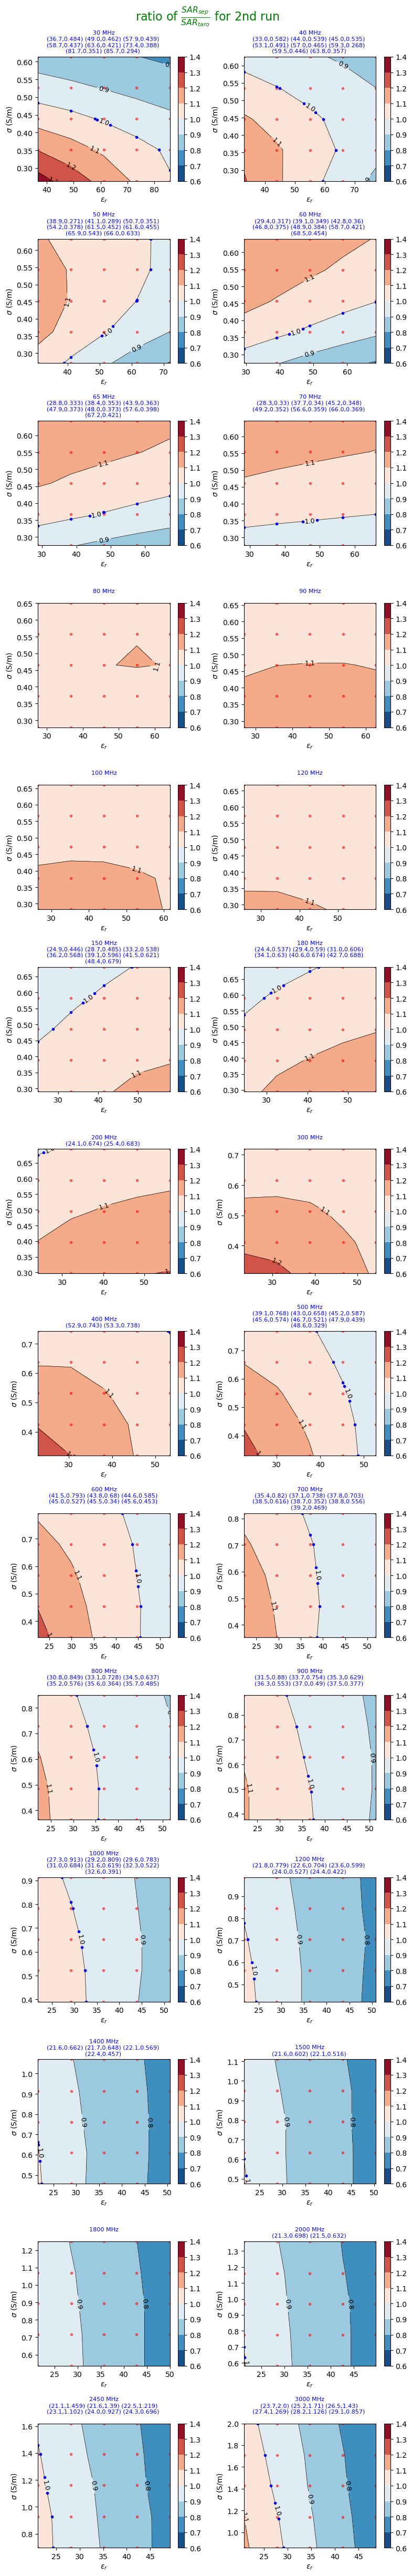

In [178]:
fig, axes = plt.subplots(14,2,figsize=(8,50)) #,sharex=True,sharey=True)
axes = axes.flatten()
levels = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
ixlev1 = levels.index(1)
coords = []

for i, (fMHz, g) in enumerate(dfSAR2b.groupby('fMHz')):
    if fMHz < 10000:
        # draw contour plot for each fMHz
        er = g.er.values.reshape(5,5)
        sigma = g.sigma.values.reshape(5,5)
        SARratio = g.SARratio.values.reshape(5,5)
        CS = axes[i].contour(er,sigma,SARratio,levels=levels,
                             linewidths=0.5,colors='black')
        axes[i].clabel(CS, inline=True, fontsize=9)
        cntr2 = axes[i].contourf(er,sigma,SARratio,levels=levels,
                    cmap="RdBu_r")
        fig.colorbar(cntr2, ax=axes[i])
        axes[i].plot(er,sigma,'ro',ms=3,alpha=0.5)
        axes[i].set(xlabel=r'$\epsilon_r$',ylabel=r'$\sigma$ (S/m)')
        
        # Calculate and print the er/sigma coordinates for R=1
        coord = [[fMHz]+c for path in CS.collections[ixlev1].get_paths() for c in path.vertices.tolist()]
        coords = coords + coord
        coorddf = pd.DataFrame(coord, columns=['fMHz','er','sigma']).sort_values('er').reset_index()
        
        # Plot those R=1 coordinate points
        axes[i].plot(coorddf.er,coorddf.sigma,'bo',markersize=3)
        
        # list the R=1 coordinates in the title
        coordpairs = ''
        for ix, c in coorddf.iterrows():
            coordpairs += f'({round(c.er,1)},{round(c.sigma,3)}) '
            if (ix+1) % 3 == 0:
                coordpairs += '\n'
        title = f'{fMHz:g} MHz\n' + coordpairs
        axes[i].set_title(title, fontsize=8, color='blue')        

fig.suptitle(r'ratio of $\frac{SAR_{sep}}{SAR_{taro}}$ for 2nd run',
             color='green', fontsize=16)
fig.tight_layout(rect=(0,0,1,0.985))
coordsdf2b = pd.DataFrame(coords, columns=['fMHz','er','sigma'])

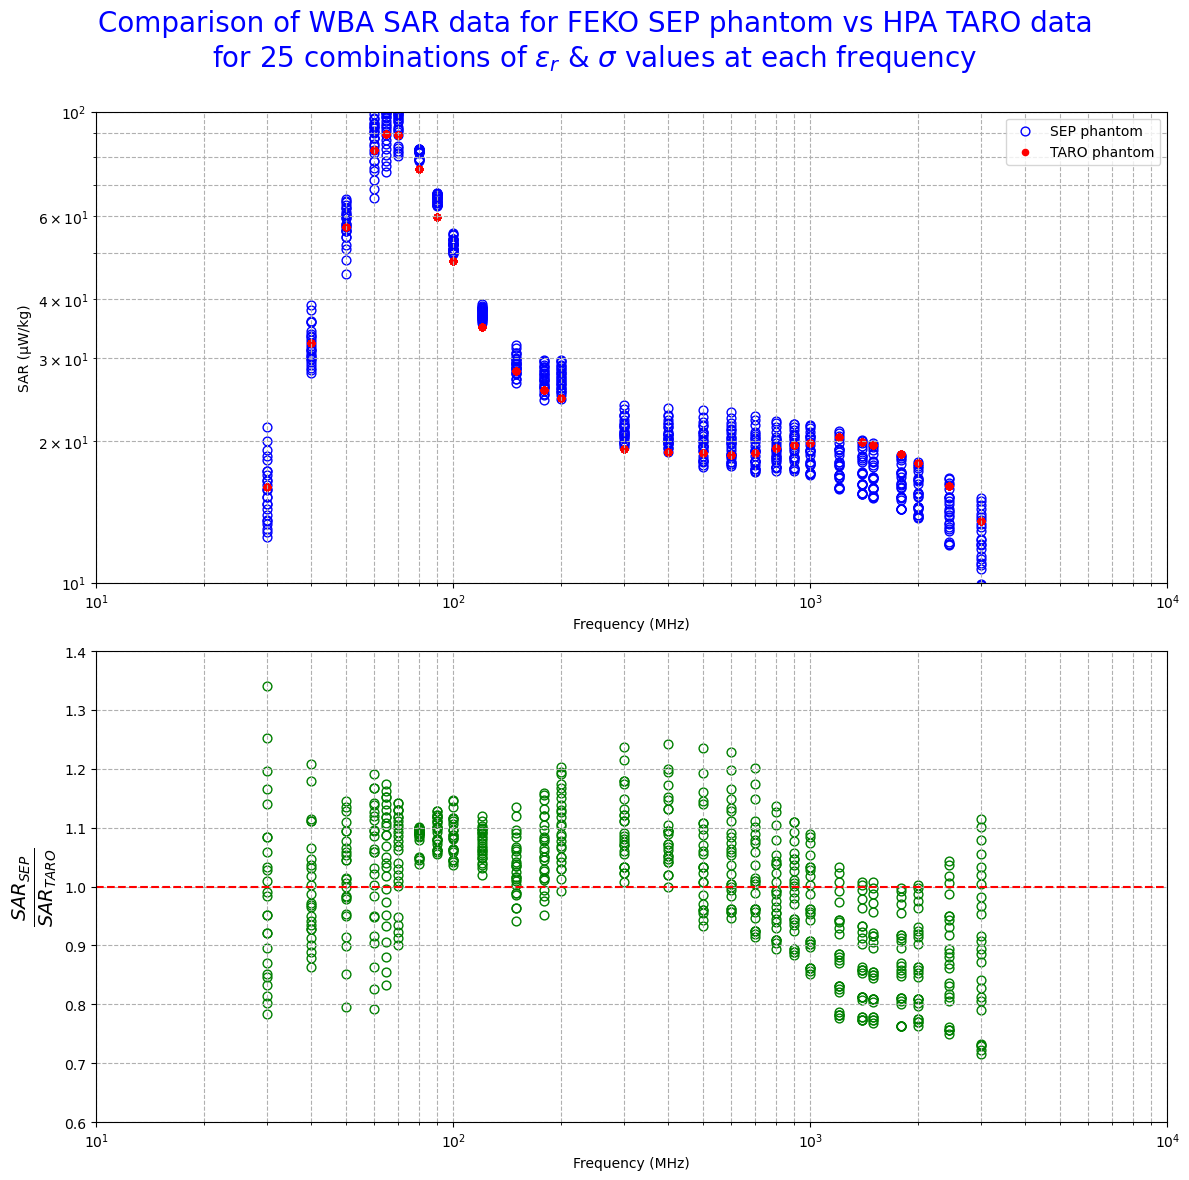

In [107]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(12,12))
plt.suptitle('Comparison of WBA SAR data for FEKO SEP phantom vs HPA TARO data\nfor 25 combinations of $\epsilon_r$ & $\sigma$ values at each frequency',
             color='blue',fontsize=20)

# top plot
dfSAR2b.plot(x='fMHz',y='SARsep',kind='scatter',color="none", edgecolor="blue",s=40,
           ax=ax1,label='SEP phantom')
dfSAR2b.plot(x='fMHz',y='SARtaro',kind='scatter',color='r',
           ax=ax1, label='TARO phantom')
ax1.set_ylim([10,100])
ax1.set_xlim([10,10_000])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('SAR (µW/kg)')
ax1.legend()
ax1.grid(True, which='both',ls='--')

# bottom plot
dfSAR2b.plot(x='fMHz',y='SARratio',kind='scatter',color="none", 
            edgecolor="green",s=40, ax=ax2)
ax2.axhline(y=1, color='r', linestyle='--')
ax2.set_ylim([0.6,1.4])
ax2.set_xlim([10,10_000])
ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{SAR_{SEP}}{SAR_{TARO}}$', fontsize=20)
ax2.set_xlabel('Frequency (MHz)')
ax2.grid(True, which='both',ls='--')
fig.tight_layout(rect=(0,0,1,0.98))

# Save the figure
fig.savefig('../plots/FEKO SEP vs HPA WBA SAR.png');


From the plots above it is clear that the `SARsep` values are too high in comparison with the SARtaro values. Therefore need to reduce the tissue dielectric vlaues to a lower level, say $\frac{1}{2}$ of muscle tissue values.

In [179]:
coordsdf2b

fMHz         er     sigma
0      30.0  36.712332  0.483723
1      30.0  49.000000  0.461518
2      30.0  57.946667  0.439000
3      30.0  58.724399  0.436756
4      30.0  63.624796  0.421254
..      ...        ...       ...
120  3000.0  25.233333  1.710000
121  3000.0  26.507692  1.430000
122  3000.0  27.403297  1.269218
123  3000.0  28.164692  1.126414
124  3000.0  29.081429  0.857000

[125 rows x 3 columns]

In [180]:
alt.Chart(dfSAR2b).mark_circle(
).encode(
    alt.X('fMHz:Q',scale=alt.Scale(zero=False,type="log")),
    alt.Y('er:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('fMHz', scale=alt.Scale(scheme='viridis')),
    tooltip=['fMHz','er','sigma']
).properties(
    width=300,
    height=250,
).repeat(
    row=['fMHz'],
    column=['er', 'sigma']
).properties(
    title="ScatterMatrix for first 2/3 muscle trial"
) #.interactive()

alt.RepeatChart(...)

In [181]:
alt.Chart(dfSAR2b).mark_circle(
).encode(
    alt.X(alt.repeat("column"), type='quantitative', scale=alt.Scale(zero=False,type='log')),
    alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    color=alt.Color('fMHz', scale=alt.Scale(scheme='viridis')),
    tooltip=['fMHz','er','sigma']
).properties(
    width=400,
    height=300,
).repeat(
    row=['SARratio'],
    column=['er', 'sigma']
).properties(
    title="ScatterMatrix for first 2/3 muscle trial"
) #.interactive()

alt.RepeatChart(...)

In [182]:
cdf = coordsdf2b.copy()
cdf['freq range'] = 'mid'
cdf.loc[cdf.fMHz <= 100, 'freq range'] = 'low'
cdf.loc[cdf.fMHz >= 1000,'freq range'] = 'high' 


brush = alt.selection_multi()

chart = alt.Chart(cdf).mark_point().encode(
    x=alt.X('fMHz:Q',scale=alt.Scale(zero=False,type="log",domain=[30, 3000])),
    y='er:Q',
    color=alt.condition(brush,'freq range:N',alt.value('lightgray')),
    tooltip=['fMHz:Q','er:Q','sigma:Q']
).add_selection(
    brush
).properties(
    width=500,
    height=500
)

chart | chart.encode(y='sigma:Q')

alt.HConcatChart(...)

## Runs 1 & 2
Combines data from the first run with data from run 2

In [276]:
# Load SAR data from run 1
FEKO_SEP_file_1 = './data/results_human-phantom-height1.72-vol6.07353E-2.csv'
dfSAR1 = loadSAR(taroSAR, FEKO_SEP_file_1)
dfSAR1.head(25)

fMHz     er   sigma         P  SARsep  SARtaro  SARratio
0    30.0  48.63  0.2957  0.001183  20.301    15.96  1.271992
1    30.0  64.84  0.3866  0.001007  17.311    15.96  1.084649
2    30.0  81.05  0.4601  0.000885  15.223    15.96  0.953822
3    40.0  42.86  0.2922  0.002187  37.729    32.20  1.171708
4    40.0  57.14  0.3852  0.002008  34.395    32.20  1.068168
5    40.0  71.43  0.4620  0.001840  31.666    32.20  0.983416
6    50.0  39.39  0.2863  0.003449  59.020    56.93  1.036712
7    50.0  52.52  0.3809  0.003445  58.990    56.93  1.036185
8    50.0  65.65  0.4613  0.003345  57.383    56.93  1.007957
9    60.0  37.07  0.2798  0.004531  77.132    82.78  0.931771
10   60.0  49.43  0.3758  0.004894  83.401    82.78  1.007502
11   60.0  61.78  0.4599  0.005052  86.150    82.78  1.040710
12   65.0  36.18  0.2765  0.004859  82.474    89.44  0.922115
13   65.0  48.24  0.3731  0.005327  90.550    89.44  1.012411
14   65.0  60.29  0.4591  0.005585  94.856    89.44  1.060555
15   70.0  35.41  0.2732  0.004981  84.668    89.38  0.947281
16   70.0  47.21  0.3704  0.005472  92.629    89.38  1.036350
17   70.0  59.02  0.4584  0.005726  97.286    89.38  1.088454
18   80.0  34.16  0.2668  0.004713  79.572    75.58  1.052818
19   80.0  45.55  0.3652  0.004971  83.917    75.58  1.110307
20   80.0  56.93  0.4569  0.005043  85.218    75.58  1.127521
21   90.0  33.18  0.2607  0.004064  68.507    59.66  1.148290
22   90.0  44.24  0.3602  0.004074  68.753    59.66  1.152414
23   90.0  55.30  0.4556  0.004007  67.490    59.66  1.131244
24  100.0  32.40  0.2550  0.003378  56.842    48.11  1.181501

In [277]:
# Combine SAR data for runs 1 and 2
dfSAR12 = pd.concat([dfSAR1,dfSAR2])
dfSAR12

fMHz       er   sigma         P  SARsep  SARtaro  SARratio
0     30.0  48.6300  0.2957  0.001183  20.301    15.96  1.271992
1     30.0  64.8400  0.3866  0.001007  17.311    15.96  1.084649
2     30.0  81.0500  0.4601  0.000885  15.223    15.96  0.953822
3     40.0  42.8600  0.2922  0.002187  37.729    32.20  1.171708
4     40.0  57.1400  0.3852  0.002008  34.395    32.20  1.068168
..     ...      ...     ...       ...     ...      ...       ...
210  100.0  43.9814  0.2830  0.003319  54.644    48.11  1.135814
211  100.0  43.9814  0.3774  0.003254  53.583    48.11  1.113760
212  100.0  43.9814  0.4717  0.003179  52.342    48.11  1.087965
213  100.0  43.9814  0.5661  0.003111  51.223    48.11  1.064706
214  100.0  43.9814  0.6604  0.003054  50.284    48.11  1.045188

[299 rows x 7 columns]

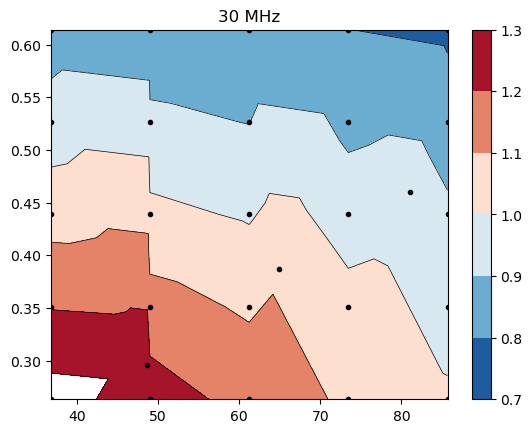

In [278]:
fMHz = 30
fig, ax = plt.subplots(1,1)
df = dfSAR12[dfSAR12.fMHz==30].sort_values('fMHz')
levels = [0.7,0.8,0.9,1,1.1,1.2,1.3]

ax.tricontour(df.er,df.sigma,df.SARratio,levels=levels,
              linewidths=0.5, colors='k')
cntr2 = ax.tricontourf(df.er,df.sigma,df.SARratio,levels=levels,
                       cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax)
ax.plot(df.er,df.sigma, 'ko', ms=3)
ax.set_title(f'{fMHz} MHz')

plt.subplots_adjust(hspace=0.5)

In [279]:
dfSAR1.fMHz.unique()
np.ceil(3/2)
len(dfSAR1.fMHz.unique())

28

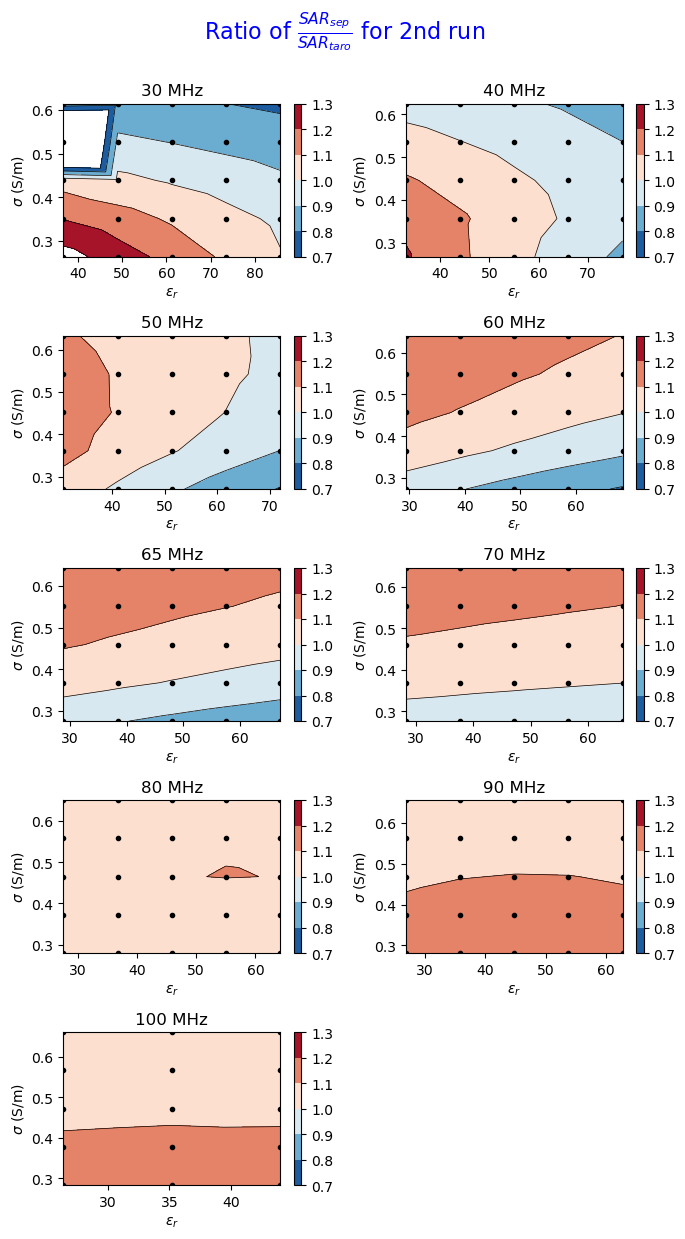

In [197]:
dfSAR = dfSAR2
nf = len(dfSAR.fMHz.unique())
nrows = int(np.ceil(nf/2))
levels = [0.7,0.8,0.9,1,1.1,1.2,1.3]
height = nf*1.4
fig, axes = plt.subplots(nrows,2,figsize=(7,height))
axes = axes.flatten()
for i, (fMHz, g) in enumerate(dfSAR.groupby('fMHz')):
    ax = axes[i]
    ax.tricontour(g.er,g.sigma,g.SARratio,levels=levels,
                  linewidths=0.5, colors='k')
    cntr2 = ax.tricontourf(g.er,g.sigma,g.SARratio,levels=levels,
                           cmap="RdBu_r")
    fig.colorbar(cntr2, ax=ax)
    ax.plot(g.er,g.sigma, 'ko', ms=3)
    ax.set_title(f'{fMHz:g} MHz')
    ax.set(xlabel=r'$\epsilon_r$',ylabel=r'$\sigma$ (S/m)')

if nf%2 == 1:
    axes[-1].remove()
fig.suptitle('Ratio of $\\frac{SAR_{sep}}{SAR_{taro}}$ for 2nd run\n',
             color='blue', fontsize=16)
fig.tight_layout()

In [178]:
nf%2

1

## Run 3: 1/2 muscle tissue dielectric values

In [46]:
# Set Dimbylow cross lab validation frequencies
freqs2 = [80, 90, 100, 120, 150, 180, 200, 300, 
         400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1500, 1800, 
         2000, 2450, 3000]

# Calculate 1/2 tissue dielectric values for muscle
tlist = []
for fMHz in freqs2:
    er, sigma = tissue_dielectric(gtdp.loc['muscle'], fMHz, factor=0.5)
    tlist.append([fMHz,er,sigma])

cols=('fMHz','er','sigma')
diel = pd.DataFrame(tlist,columns=cols)
diel.head()

fMHz         er     sigma
0    80  34.384137  0.348842
1    90  33.609186  0.351427
2   100  32.986032  0.353796
3   120  32.043965  0.358050
4   150  31.089167  0.363596

### Calculate $\epsilon_r$ and $\sigma$ investigation points

In [47]:
diel_list = []
fraclist = [0.6, 0.8, 1, 1.2, 1.4]
for row in diel.itertuples():
    er, sigma = row.er, row.sigma
    for frac_er in fraclist:
        for frac_sigma in fraclist:
            erf = row.er * frac_er
            sigmaf = row.sigma * frac_sigma
            diel_list.append([row.fMHz, erf, sigmaf])
            
diel_cols = ['fMHz','er','sigma']
diel2 = pd.DataFrame(diel_list, columns=cols).round(4)
diel2.to_excel('dielectric test values v2.xlsx',index=False)
diel2.to_csv('dielectric test values v2.csv',index=False)
diel2.head(25)

fMHz       er   sigma
0     80  20.6305  0.2093
1     80  20.6305  0.2791
2     80  20.6305  0.3488
3     80  20.6305  0.4186
4     80  20.6305  0.4884
5     80  27.5073  0.2093
6     80  27.5073  0.2791
7     80  27.5073  0.3488
8     80  27.5073  0.4186
9     80  27.5073  0.4884
10    80  34.3841  0.2093
11    80  34.3841  0.2791
12    80  34.3841  0.3488
13    80  34.3841  0.4186
14    80  34.3841  0.4884
15    80  41.2610  0.2093
16    80  41.2610  0.2791
17    80  41.2610  0.3488
18    80  41.2610  0.4186
19    80  41.2610  0.4884
20    80  48.1378  0.2093
21    80  48.1378  0.2791
22    80  48.1378  0.3488
23    80  48.1378  0.4186
24    80  48.1378  0.4884

In [174]:
FEKO_SEP_file_3 = './data/results_human-phantom-height1.72m 0.5muscle.csv'
dfSAR3 = loadSAR(taroSAR, FEKO_SEP_file_3)
dfSAR3.head(25)

fMHz       er   sigma         P  SARsep  SARtaro  SARratio
0     80  20.6305  0.2093  0.004407    72.6    75.58  0.960572
1     80  20.6305  0.2791  0.004730    77.9    75.58  1.030696
2     80  20.6305  0.3488  0.004893    80.6    75.58  1.066420
3     80  20.6305  0.4186  0.004968    81.8    75.58  1.082297
4     80  20.6305  0.4884  0.004995    82.2    75.58  1.087589
5     80  27.5073  0.2093  0.004446    73.2    75.58  0.968510
6     80  27.5073  0.2791  0.004765    78.5    75.58  1.038635
7     80  27.5073  0.3488  0.004922    81.0    75.58  1.071712
8     80  27.5073  0.4186  0.004993    82.2    75.58  1.087589
9     80  27.5073  0.4884  0.005015    82.6    75.58  1.092882
10    80  34.3841  0.2093  0.004476    73.7    75.58  0.975126
11    80  34.3841  0.2791  0.004792    78.9    75.58  1.043927
12    80  34.3841  0.3488  0.004945    81.4    75.58  1.077004
13    80  34.3841  0.4186  0.005012    82.5    75.58  1.091559
14    80  34.3841  0.4884  0.005031    82.8    75.58  1.095528
15    80  41.2610  0.2093  0.004497    74.0    75.58  0.979095
16    80  41.2610  0.2791  0.004811    79.2    75.58  1.047896
17    80  41.2610  0.3488  0.004962    81.7    75.58  1.080974
18    80  41.2610  0.4186  0.005025    82.7    75.58  1.094205
19    80  41.2610  0.4884  0.005043    83.0    75.58  1.098174
20    80  48.1378  0.2093  0.004508    74.2    75.58  0.981741
21    80  48.1378  0.2791  0.004822    79.4    75.58  1.050542
22    80  48.1378  0.3488  0.004971    81.8    75.58  1.082297
23    80  48.1378  0.4186  0.005034    82.9    75.58  1.096851
24    80  48.1378  0.4884  0.005050    83.2    75.58  1.100820

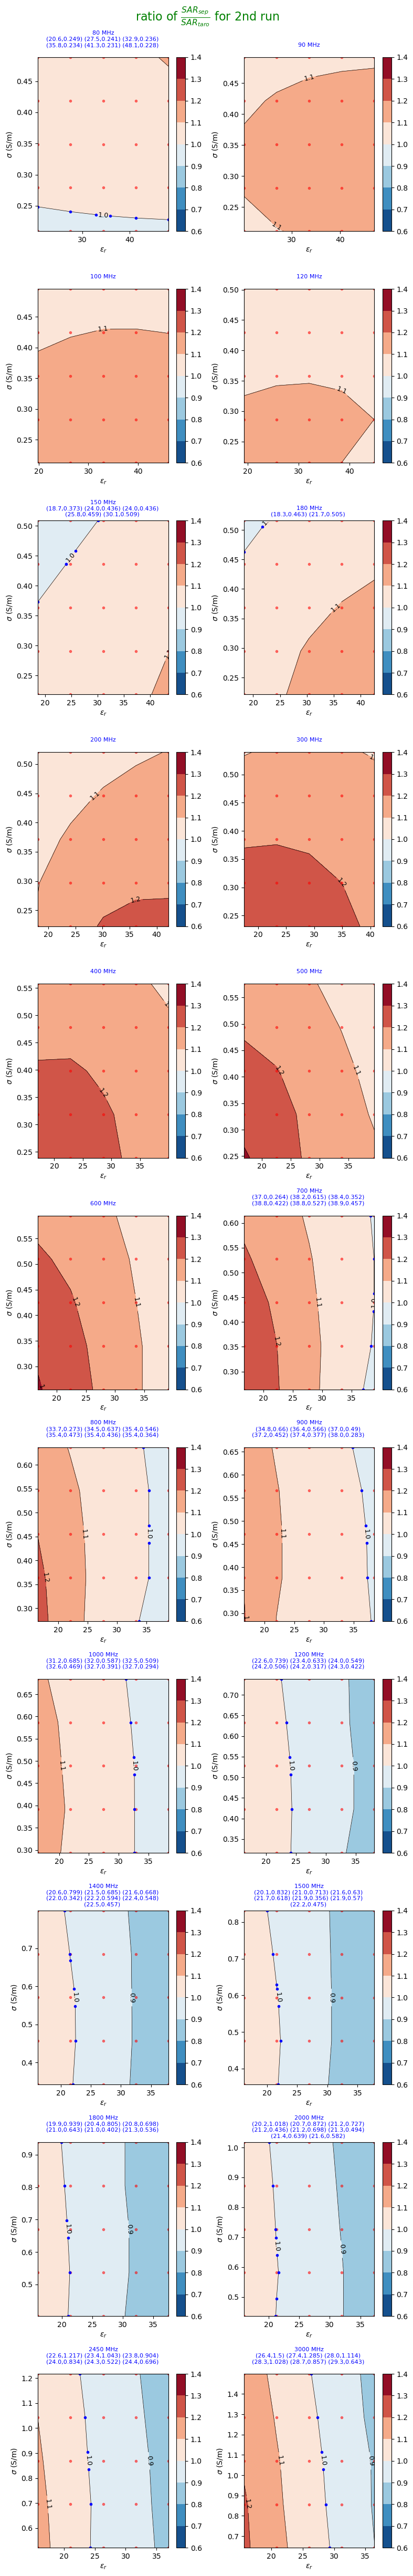

In [177]:
fig, axes = plt.subplots(11,2,figsize=(8,50)) #,sharex=True,sharey=True)
axes = axes.flatten()
levels = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
ixlev1 = levels.index(1)
coords = []

for i, (fMHz, g) in enumerate(dfSAR3.groupby('fMHz')):
    if fMHz < 10000:
        # draw contour plot for each fMHz
        er = g.er.values.reshape(5,5)
        sigma = g.sigma.values.reshape(5,5)
        SARratio = g.SARratio.values.reshape(5,5)
        CS = axes[i].contour(er,sigma,SARratio,levels=levels,
                             linewidths=0.5,colors='black')
        axes[i].clabel(CS, inline=True, fontsize=9)
        cntr2 = axes[i].contourf(er,sigma,SARratio,levels=levels,
                    cmap="RdBu_r")
        fig.colorbar(cntr2, ax=axes[i])
        axes[i].plot(er,sigma,'ro',ms=3,alpha=0.5)
        axes[i].set(xlabel=r'$\epsilon_r$',ylabel=r'$\sigma$ (S/m)')
        
        # Calculate and print the er/sigma coordinates for R=1
        coord = [[fMHz]+c for path in CS.collections[ixlev1].get_paths() for c in path.vertices.tolist()]
        coords = coords + coord
        coorddf = pd.DataFrame(coord, columns=['fMHz','er','sigma']).sort_values('er').reset_index()
        
        # Plot those R=1 coordinate points
        axes[i].plot(coorddf.er,coorddf.sigma,'bo',markersize=3)
        
        # list the R=1 coordinates in the title
        coordpairs = ''
        for ix, c in coorddf.iterrows():
            coordpairs += f'({round(c.er,1)},{round(c.sigma,3)}) '
            if (ix+1) % 3 == 0:
                coordpairs += '\n'
        title = f'{fMHz:g} MHz\n' + coordpairs
        axes[i].set_title(title, fontsize=8, color='blue')        

fig.suptitle(r'ratio of $\frac{SAR_{sep}}{SAR_{taro}}$ for 2nd run',
             color='green', fontsize=16)
fig.tight_layout(rect=(0,0,1,0.985))
coordsdf3 = pd.DataFrame(coords, columns=['fMHz','er','sigma'])

In [183]:
cdf = coordsdf3.copy()
cdf['freq range'] = 'mid'
cdf.loc[cdf.fMHz <= 100, 'freq range'] = 'low'
cdf.loc[cdf.fMHz >= 1000,'freq range'] = 'high' 


brush = alt.selection_multi()

chart = alt.Chart(cdf).mark_point().encode(
    x=alt.X('fMHz:Q',scale=alt.Scale(zero=False,type="log",domain=[30, 3000])),
    y='er:Q',
    color=alt.condition(brush,'freq range:N',alt.value('lightgray')),
    tooltip=['fMHz:Q','er:Q','sigma:Q']
).add_selection(
    brush
).properties(
    width=500,
    height=500
)

chart | chart.encode(y='sigma:Q')

alt.HConcatChart(...)

## Run 3b: combined run 2b (2/3 muscle) and run 3 (0.5 muscle tissue)

In [191]:
# Load run 2b data
FEKO_SEP_file_2b = './data/results_human-phantom-height1.72m-material-properties-2023-05-29.csv'
dfSAR2b = loadSAR(taroSAR, FEKO_SEP_file_2b)
dfSAR2b['run'] = '2b'

# Load run 3 data
FEKO_SEP_file_3 = './data/results_human-phantom-height1.72m 0.5muscle.csv'
dfSAR3 = loadSAR(taroSAR, FEKO_SEP_file_3)
dfSAR3['run'] = '3'

# Combine run 2b and 3
dfSAR3b = pd.concat([dfSAR2b,dfSAR3])
# dfSAR3b = dfSAR3b.sort_values(['fMHz','er','sigma'])
dfSAR3b

fMHz       er   sigma         P  SARsep  SARtaro  SARratio run
0      30.0  36.7000  0.2630  0.001300  21.400    15.96  1.340852  2b
1      30.0  36.7000  0.3510  0.001160  19.100    15.96  1.196742  2b
2      30.0  36.7000  0.4390  0.001030  16.900    15.96  1.058897  2b
3      30.0  36.7241  0.5264  0.000915  15.063    15.96  0.943797  2b
4      30.0  36.7000  0.6140  0.000823  13.600    15.96  0.852130  2b
..      ...      ...     ...       ...     ...      ...       ...  ..
545  3000.0  36.4406  0.6426  0.000741  12.200    13.54  0.901034   3
546  3000.0  36.4406  0.8568  0.000738  12.100    13.54  0.893648   3
547  3000.0  36.4406  1.0711  0.000732  12.100    13.54  0.893648   3
548  3000.0  36.4406  1.2853  0.000725  11.900    13.54  0.878877   3
549  3000.0  36.4406  1.4995  0.000718  11.800    13.54  0.871492   3

[1250 rows x 8 columns]

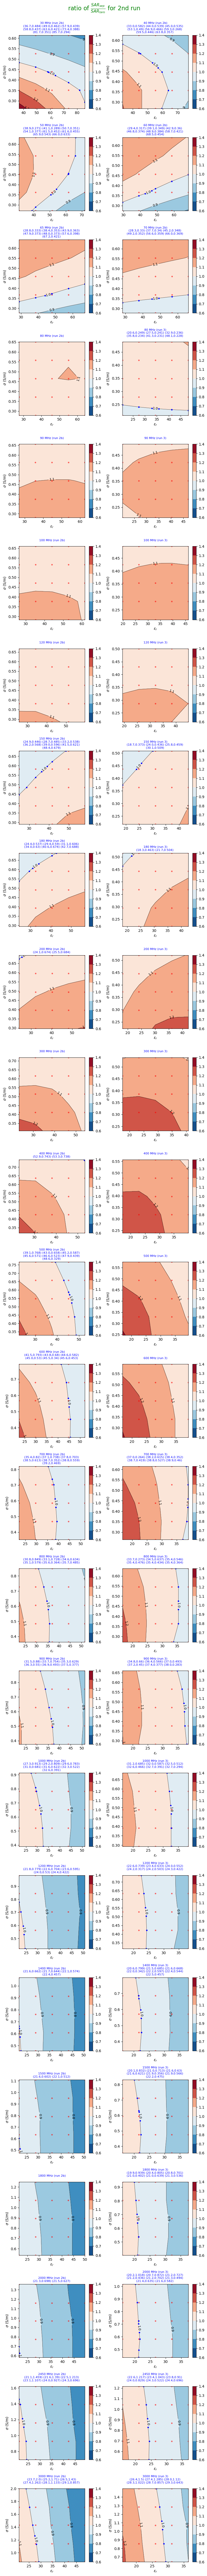

In [206]:
fig, axes = plt.subplots(25,2,figsize=(8,100)) #,sharex=True,sharey=True)
axes = axes.flatten()
levels = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
ixlev1 = levels.index(1)
coords = []

for i, ((fMHz,run), g) in enumerate(dfSAR3b.groupby(['fMHz','run'])):
    # draw contour plot for each fMHz
    er = g.er.values.reshape(5,5)
    sigma = g.sigma.values.reshape(5,5)
    SARratio = g.SARratio.values.reshape(5,5)
    CS = axes[i].contour(er,sigma,SARratio,levels=levels,
                         linewidths=0.5,colors='black')
    axes[i].clabel(CS, inline=True, fontsize=9)
    cntr2 = axes[i].contourf(er,sigma,SARratio,levels=levels,
                cmap="RdBu_r")
    fig.colorbar(cntr2, ax=axes[i])
    axes[i].plot(er,sigma,'ro',ms=3,alpha=0.5)
    axes[i].set(xlabel=r'$\epsilon_r$',ylabel=r'$\sigma$ (S/m)')

    # Calculate and print the er/sigma coordinates for R=1
    coord = [[fMHz]+c for path in CS.collections[ixlev1].get_paths() for c in path.vertices.tolist()]
    coords = coords + coord
    coorddf = pd.DataFrame(coord, columns=['fMHz','er','sigma']).sort_values('er').reset_index()

    # Plot those R=1 coordinate points
    axes[i].plot(coorddf.er,coorddf.sigma,'bo',markersize=3)

    # list the R=1 coordinates in the title
    coordpairs = ''
    for ix, c in coorddf.iterrows():
        coordpairs += f'({round(c.er,1)},{round(c.sigma,3)}) '
        if (ix+1) % 3 == 0:
            coordpairs += '\n'
    title = f'{fMHz:g} MHz (run {run})\n' + coordpairs
    axes[i].set_title(title, fontsize=8, color='blue')        

fig.suptitle(r'ratio of $\frac{SAR_{sep}}{SAR_{taro}}$ for 2nd run',
             color='green', fontsize=16)
fig.tight_layout(rect=(0,0,1,0.98))
coordsdf3b = pd.DataFrame(coords, columns=['fMHz','er','sigma'])
fig.savefig('../plots/R contours run 2b & 3',dpi=300)

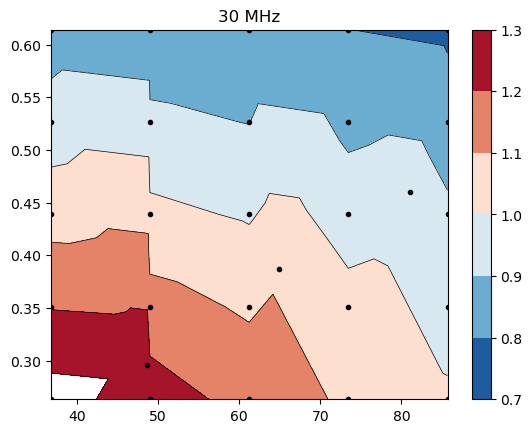

In [278]:
fMHz = 30
fig, ax = plt.subplots(1,1)
df = dfSAR12[dfSAR12.fMHz==30].sort_values('fMHz')
levels = [0.7,0.8,0.9,1,1.1,1.2,1.3]

ax.tricontour(df.er,df.sigma,df.SARratio,levels=levels,
              linewidths=0.5, colors='k')
cntr2 = ax.tricontourf(df.er,df.sigma,df.SARratio,levels=levels,
                       cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax)
ax.plot(df.er,df.sigma, 'ko', ms=3)
ax.set_title(f'{fMHz} MHz')

plt.subplots_adjust(hspace=0.5)

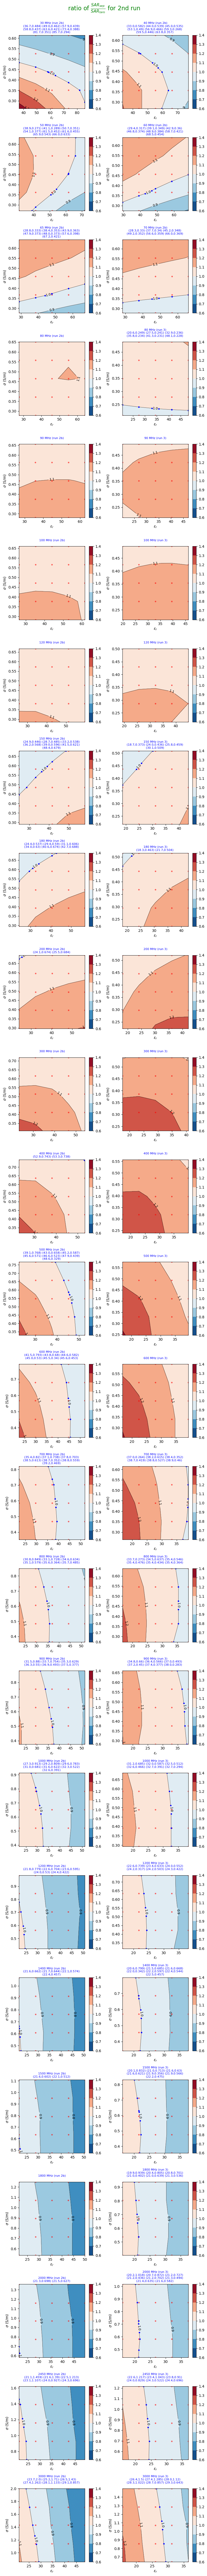

In [206]:
fig, axes = plt.subplots(25,2,figsize=(8,100)) #,sharex=True,sharey=True)
axes = axes.flatten()
levels = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
ixlev1 = levels.index(1)
coords = []

for i, ((fMHz,run), g) in enumerate(dfSAR3b.groupby(['fMHz','run'])):
    # draw contour plot for each fMHz
    er = g.er.values.reshape(5,5)
    sigma = g.sigma.values.reshape(5,5)
    SARratio = g.SARratio.values.reshape(5,5)
    CS = axes[i].contour(er,sigma,SARratio,levels=levels,
                         linewidths=0.5,colors='black')
    axes[i].clabel(CS, inline=True, fontsize=9)
    cntr2 = axes[i].contourf(er,sigma,SARratio,levels=levels,
                cmap="RdBu_r")
    fig.colorbar(cntr2, ax=axes[i])
    axes[i].plot(er,sigma,'ro',ms=3,alpha=0.5)
    axes[i].set(xlabel=r'$\epsilon_r$',ylabel=r'$\sigma$ (S/m)')

    # Calculate and print the er/sigma coordinates for R=1
    coord = [[fMHz]+c for path in CS.collections[ixlev1].get_paths() for c in path.vertices.tolist()]
    coords = coords + coord
    coorddf = pd.DataFrame(coord, columns=['fMHz','er','sigma']).sort_values('er').reset_index()

    # Plot those R=1 coordinate points
    axes[i].plot(coorddf.er,coorddf.sigma,'bo',markersize=3)

    # list the R=1 coordinates in the title
    coordpairs = ''
    for ix, c in coorddf.iterrows():
        coordpairs += f'({round(c.er,1)},{round(c.sigma,3)}) '
        if (ix+1) % 3 == 0:
            coordpairs += '\n'
    title = f'{fMHz:g} MHz (run {run})\n' + coordpairs
    axes[i].set_title(title, fontsize=8, color='blue')        

fig.suptitle(r'ratio of $\frac{SAR_{sep}}{SAR_{taro}}$ for 2nd run',
             color='green', fontsize=16)
fig.tight_layout(rect=(0,0,1,0.98))
coordsdf3b = pd.DataFrame(coords, columns=['fMHz','er','sigma'])
fig.savefig('../plots/R contours run 2b & 3',dpi=300)

In [275]:
from scipy.interpolate import griddata           
dff = dfSAR3b[dfSAR3b.fMHz==30]

x = dff.er
y = dff.sigma
points = [dff.er.values,dff.sigma.values]
values = dff.SARratio
xi = np.mgrid[x.min():x.max():10j, y.min():y.max():10j]
zi = griddata(points, values, xi, method='linear')                                  
plt.contour(xi, yi, zi, 10)     
plt.scatter(x, y, c=z)                                                              
plt.colorbar()    

ValueError: different number of values and points

In [273]:
np.mgrid[x.min():x.max():10j, y.min():y.max():10j]

array([[[36.7       , 36.7       , 36.7       , 36.7       ,
         36.7       , 36.7       , 36.7       , 36.7       ,
         36.7       , 36.7       ],
        [42.14444444, 42.14444444, 42.14444444, 42.14444444,
         42.14444444, 42.14444444, 42.14444444, 42.14444444,
         42.14444444, 42.14444444],
        [47.58888889, 47.58888889, 47.58888889, 47.58888889,
         47.58888889, 47.58888889, 47.58888889, 47.58888889,
         47.58888889, 47.58888889],
        [53.03333333, 53.03333333, 53.03333333, 53.03333333,
         53.03333333, 53.03333333, 53.03333333, 53.03333333,
         53.03333333, 53.03333333],
        [58.47777778, 58.47777778, 58.47777778, 58.47777778,
         58.47777778, 58.47777778, 58.47777778, 58.47777778,
         58.47777778, 58.47777778],
        [63.92222222, 63.92222222, 63.92222222, 63.92222222,
         63.92222222, 63.92222222, 63.92222222, 63.92222222,
         63.92222222, 63.92222222],
        [69.36666667, 69.36666667, 69.36666667, 69.3

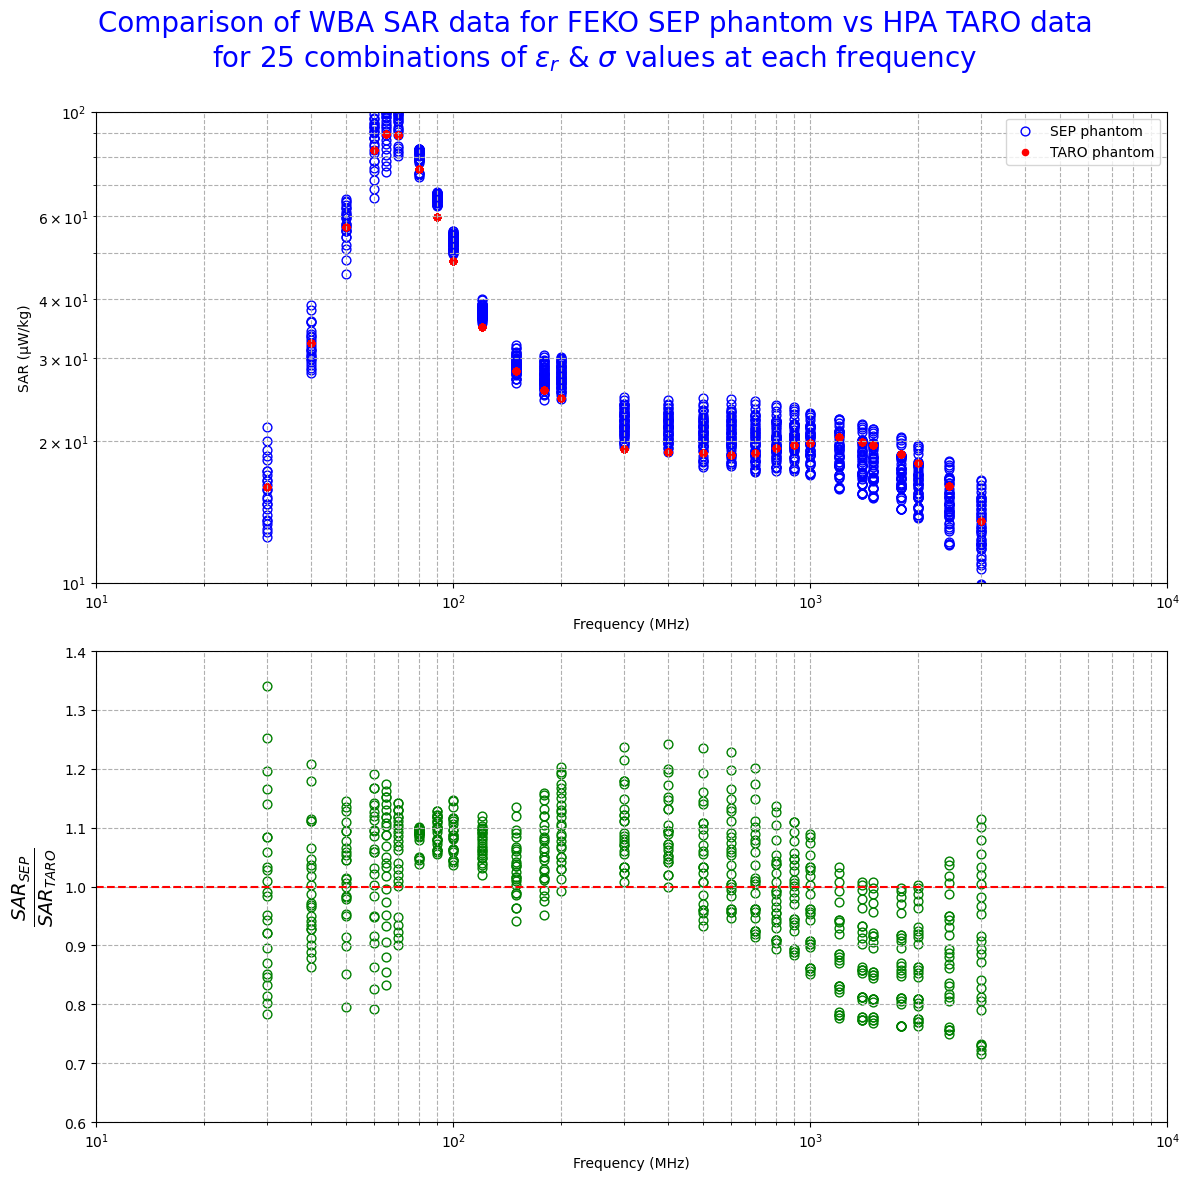

In [199]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(12,12))
plt.suptitle('Comparison of WBA SAR data for FEKO SEP phantom vs HPA TARO data\nfor 25 combinations of $\epsilon_r$ & $\sigma$ values at each frequency',
             color='blue',fontsize=20)

# top plot
dfSAR3b.plot(x='fMHz',y='SARsep',kind='scatter',color="none", edgecolor="blue",s=40,
           ax=ax1,label='SEP phantom')
dfSAR2b.plot(x='fMHz',y='SARtaro',kind='scatter',color='r',
           ax=ax1, label='TARO phantom')
ax1.set_ylim([10,100])
ax1.set_xlim([10,10_000])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('SAR (µW/kg)')
ax1.legend()
ax1.grid(True, which='both',ls='--')

# bottom plot
dfSAR2b.plot(x='fMHz',y='SARratio',kind='scatter',color="none", 
            edgecolor="green",s=40, ax=ax2)
ax2.axhline(y=1, color='r', linestyle='--')
ax2.set_ylim([0.6,1.4])
ax2.set_xlim([10,10_000])
ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{SAR_{SEP}}{SAR_{TARO}}$', fontsize=20)
ax2.set_xlabel('Frequency (MHz)')
ax2.grid(True, which='both',ls='--')
fig.tight_layout(rect=(0,0,1,0.98))

# Save the figure
fig.savefig('../plots/FEKO SEP vs HPA WBA SAR.png');


From the plots above it is clear that the `SARsep` values are too high in comparison with the SARtaro values. Therefore need to reduce the tissue dielectric vlaues to a lower level, say $\frac{1}{2}$ of muscle tissue values.

In [200]:
coordsdf3b

fMHz         er     sigma
0      30.0  36.712332  0.483723
1      30.0  49.000000  0.461518
2      30.0  57.946667  0.439000
3      30.0  58.753438  0.436672
4      30.0  63.586087  0.421387
..      ...        ...       ...
202  3000.0  27.382508  1.285300
203  3000.0  28.017519  1.120120
204  3000.0  28.315290  1.021598
205  3000.0  28.679225  0.856800
206  3000.0  29.326007  0.642600

[207 rows x 3 columns]

In [201]:
alt.Chart(dfSAR3b).mark_circle(
).encode(
    alt.X('fMHz:Q',scale=alt.Scale(zero=False,type="log")),
    alt.Y('er:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('fMHz', scale=alt.Scale(scheme='viridis')),
    tooltip=['fMHz','er','sigma']
).properties(
    width=300,
    height=250,
).repeat(
    row=['fMHz'],
    column=['er', 'sigma']
).properties(
    title="ScatterMatrix for first 2/3 muscle trial"
) #.interactive()

alt.RepeatChart(...)

In [203]:
alt.Chart(dfSAR3b).mark_circle(
).encode(
    alt.X(alt.repeat("column"), type='quantitative', scale=alt.Scale(zero=False,type='log')),
    alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    color=alt.Color('fMHz', scale=alt.Scale(scheme='viridis')),
    tooltip=['fMHz','er','sigma']
).properties(
    width=400,
    height=300,
).repeat(
    row=['SARratio'],
    column=['er', 'sigma']
).properties(
    title="ScatterMatrix for 2/3 & 0.5 muscle trial"
) #.interactive()

alt.RepeatChart(...)

In [253]:
cdf = coordsdf3b.copy()
cdf['freq range'] = 'mid'
cdf.loc[cdf.fMHz <= 100, 'freq range'] = 'low'
cdf.loc[cdf.fMHz >= 1000,'freq range'] = 'high' 


brush = alt.selection_multi()

chart = alt.Chart(cdf).mark_point().encode(
    x=alt.X('fMHz:Q',scale=alt.Scale(zero=False,type="log",domain=[30, 3000])),
    y='er:Q',
    color=alt.condition(brush,'freq range:N',alt.value('lightgray')),
    tooltip=['fMHz:Q','er:Q','sigma:Q']
).add_selection(
    brush
).properties(
    width=500,
    height=500
)

chart | chart.encode(y='sigma:Q')

alt.HConcatChart(...)

## Run 3c: Use unstructured data from runs 1, 2 and 3

In [299]:
# Load run 1 data
FEKO_SEP_file_1 = './data/results_human-phantom-height1.72-vol6.07353E-2.csv'
dfSAR1 = loadSAR(taroSAR, FEKO_SEP_file_1)
dfSAR1['run'] = '1'

# Load run 2b data
FEKO_SEP_file_2b = './data/results_human-phantom-height1.72m-material-properties-2023-05-29.csv'
dfSAR2b = loadSAR(taroSAR, FEKO_SEP_file_2b)
dfSAR2b['run'] = '2b'

# Load run 3 data
FEKO_SEP_file_3 = './data/results_human-phantom-height1.72m 0.5muscle.csv'
dfSAR3 = loadSAR(taroSAR, FEKO_SEP_file_3)
dfSAR3['run'] = '3'

# Combine runs 1, 2b and 3
dfSAR3c = pd.concat([dfSAR1,dfSAR2b,dfSAR3])
dfSAR3c = dfSAR3c.sort_values(['fMHz','er','sigma'])
dfSAR3c.head(30)

fMHz       er   sigma         P  SARsep  SARtaro  SARratio run
0   30.0  36.7000  0.2630  0.001300  21.400    15.96  1.340852  2b
1   30.0  36.7000  0.3510  0.001160  19.100    15.96  1.196742  2b
2   30.0  36.7000  0.4390  0.001030  16.900    15.96  1.058897  2b
4   30.0  36.7000  0.6140  0.000823  13.600    15.96  0.852130  2b
3   30.0  36.7241  0.5264  0.000915  15.063    15.96  0.943797  2b
0   30.0  48.6300  0.2957  0.001183  20.301    15.96  1.271992   1
5   30.0  49.0000  0.2630  0.001210  20.000    15.96  1.253133  2b
6   30.0  49.0000  0.3510  0.001110  18.200    15.96  1.140351  2b
7   30.0  49.0000  0.4390  0.000993  16.400    15.96  1.027569  2b
8   30.0  49.0000  0.5260  0.000893  14.700    15.96  0.921053  2b
9   30.0  49.0000  0.6140  0.000808  13.300    15.96  0.833333  2b
10  30.0  61.2000  0.2630  0.001130  18.600    15.96  1.165414  2b
11  30.0  61.2000  0.3510  0.001050  17.300    15.96  1.083960  2b
12  30.0  61.2000  0.4390  0.000959  15.800    15.96  0.989975  2b
13  30.0  61.2000  0.5260  0.000870  14.300    15.96  0.895990  2b
14  30.0  61.2000  0.6140  0.000793  13.000    15.96  0.814536  2b
1   30.0  64.8400  0.3866  0.001007  17.311    15.96  1.084649   1
15  30.0  73.4000  0.2630  0.001050  17.300    15.96  1.083960  2b
16  30.0  73.4000  0.3510  0.001000  16.500    15.96  1.033835  2b
17  30.0  73.4000  0.4390  0.000925  15.200    15.96  0.952381  2b
18  30.0  73.4000  0.5260  0.000847  13.900    15.96  0.870927  2b
19  30.0  73.4000  0.6140  0.000776  12.800    15.96  0.802005  2b
2   30.0  81.0500  0.4601  0.000885  15.223    15.96  0.953822   1
20  30.0  85.7000  0.2630  0.000976  16.100    15.96  1.008772  2b
21  30.0  85.7000  0.3510  0.000951  15.700    15.96  0.983709  2b
22  30.0  85.7000  0.4390  0.000890  14.700    15.96  0.921053  2b
23  30.0  85.7000  0.5260  0.000823  13.500    15.96  0.845865  2b
24  30.0  85.7000  0.6140  0.000759  12.500    15.96  0.783208  2b
25  40.0  33.0000  0.2680  0.002370  38.900    32.20  1.208075  2b
26  40.0  33.0000  0.3570  0.002310  38.000    32.20  1.180124  2b

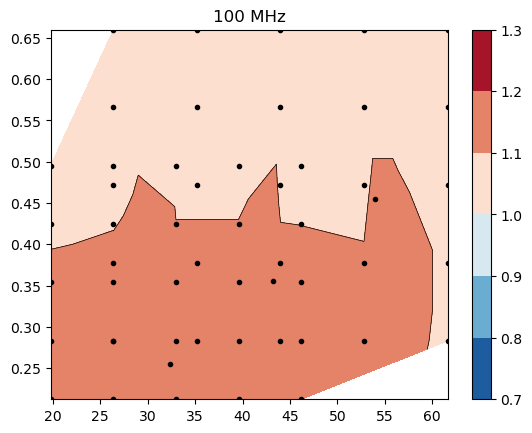

In [300]:
fMHz = 100
fig, ax = plt.subplots(1,1)
df = dfSAR3c[dfSAR3c.fMHz==fMHz].sort_values('fMHz')
levels = [0.7,0.8,0.9,1,1.1,1.2,1.3]

ax.tricontour(df.er,df.sigma,df.SARratio,levels=levels,
              linewidths=0.5, colors='k')
cntr2 = ax.tricontourf(df.er,df.sigma,df.SARratio,levels=levels,
                       cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax)
ax.plot(df.er,df.sigma, 'ko', ms=3)
ax.set_title(f'{fMHz} MHz')

plt.subplots_adjust(hspace=0.5)

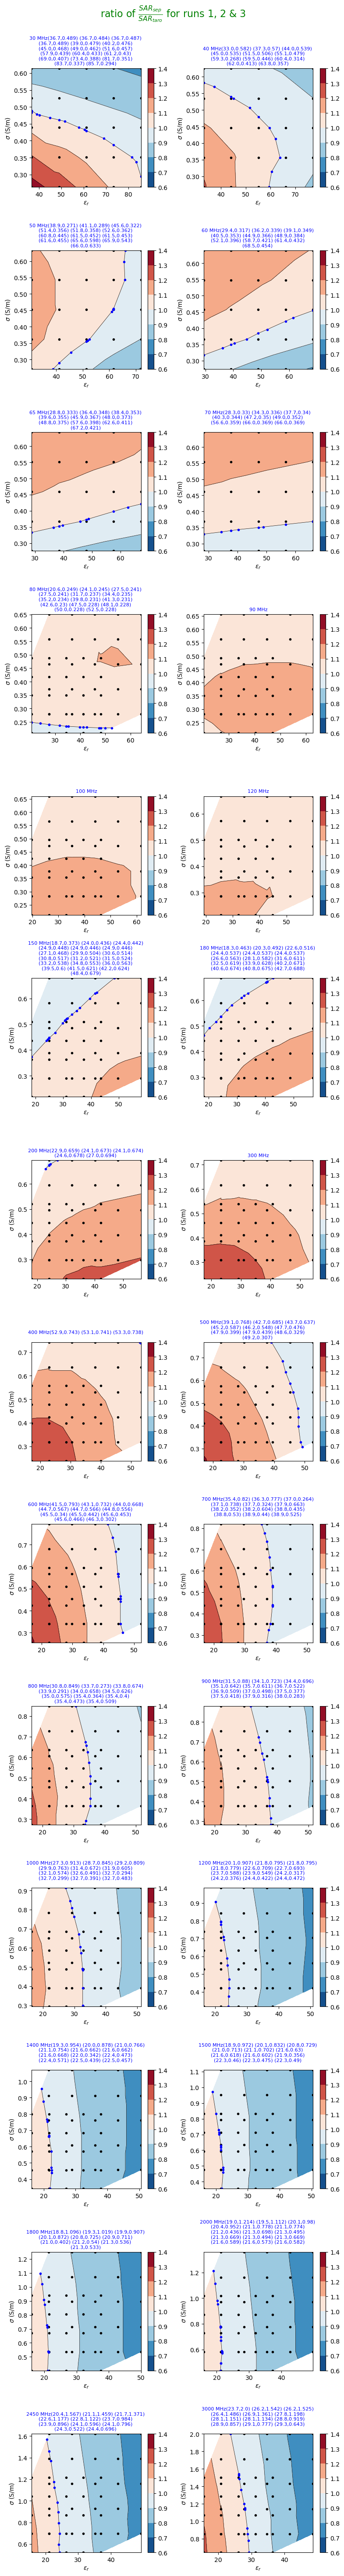

In [309]:
fig, axes = plt.subplots(14,2,figsize=(8,60))
axes = axes.flatten()
levels = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
ixlev1 = levels.index(1)
coords = []

for i, (fMHz, g) in enumerate(dfSAR3b.groupby('fMHz')):
    # draw contour plot for each fMHz
    ax = axes[i]
    CS = ax.tricontour(g.er,g.sigma,g.SARratio,levels=levels,
                       linewidths=0.5, colors='k')
    cntr2 = ax.tricontourf(g.er,g.sigma,g.SARratio,levels=levels,
                           cmap="RdBu_r")
    fig.colorbar(cntr2, ax=ax)
    ax.plot(g.er, g.sigma, 'ko', ms=3)
    ax.set_title(f'{fMHz:g} MHz')
    ax.set(xlabel=r'$\epsilon_r$',ylabel=r'$\sigma$ (S/m)')
    
    
    # er = g.er.values.reshape(5,5)
    # sigma = g.sigma.values.reshape(5,5)
    # SARratio = g.SARratio.values.reshape(5,5)
    # CS = axes[i].contour(er,sigma,SARratio,levels=levels,
    #                      linewidths=0.5,colors='black')
    # axes[i].clabel(CS, inline=True, fontsize=9)
    # cntr2 = axes[i].contourf(er,sigma,SARratio,levels=levels,
    #             cmap="RdBu_r")
    # fig.colorbar(cntr2, ax=axes[i])
    # axes[i].plot(er,sigma,'ro',ms=3,alpha=0.5)
    # axes[i].set(xlabel=r'$\epsilon_r$',ylabel=r'$\sigma$ (S/m)')

    # Calculate and print the er/sigma coordinates for R=1
    coord = [[fMHz]+c for path in CS.collections[ixlev1].get_paths() for c in path.vertices.tolist()]
    coords = coords + coord
    coorddf = pd.DataFrame(coord, columns=['fMHz','er','sigma']).sort_values('er').reset_index()

    # Plot those R=1 coordinate points
    axes[i].plot(coorddf.er,coorddf.sigma,'bo',markersize=3)

    # list the R=1 coordinates in the title
    coordpairs = ''
    for ix, c in coorddf.iterrows():
        coordpairs += f'({round(c.er,1)},{round(c.sigma,3)}) '
        if (ix+1) % 3 == 0:
            coordpairs += '\n'
    title = f'{fMHz:g} MHz' + coordpairs
    ax.set_title(title, fontsize=8, color='blue')        

fig.suptitle(r'ratio of $\frac{SAR_{sep}}{SAR_{taro}}$ for runs 1, 2 & 3',
             color='green', fontsize=16)
fig.tight_layout(rect=(0,0,1,0.98))
# coordsdf3b = pd.DataFrame(coords, columns=['fMHz','er','sigma'])
# fig.savefig('../plots/R contours run 2b & 3',dpi=300)

## Run 4: pick values from unstructured grid

In [307]:
diel4 = pd.read_excel("./data/run 4 dielectric centre values.xlsx","Sheet2")
diel4

fMHz  er  sigma
0     30  80   0.30
1     40  65   0.35
2     50  65   0.50
3     60  70   0.45
4     65  70   0.45
5     70  70   0.45
6     80  70   0.45
7     90  75   0.45
8    100  75   0.45
9    120  75   0.45
10   150  75   0.45
11   180  75   0.45
12   200  75   0.45
13   300  75   0.45
14   400  60   0.45
15   500  48   0.55
16   600  46   0.60
17   700  38   0.60
18   800  35   0.60
19   900  33   0.58
20  1000  32   0.52
21  1200  24   0.55
22  1400  23   0.58
23  1500  22   0.60
24  1800  22   0.70
25  2000  22   0.80
26  2450  25   1.00
27  3000  30   1.10

In [308]:
diel_list = []
fraclist = [0.4, 0.7, 1, 1.3, 1.6]
for row in diel4.itertuples():
    er, sigma = row.er, row.sigma
    for frac_er in fraclist:
        for frac_sigma in fraclist:
            erf = row.er * frac_er
            sigmaf = row.sigma * frac_sigma
            diel_list.append([row.fMHz, erf, sigmaf])
            
diel_cols = ['fMHz','er','sigma']
diel4 = pd.DataFrame(diel_list, columns=cols).round(4)
diel4.to_excel('dielectric test values run4.xlsx',index=False)
diel4.to_csv('dielectric test values run4.csv',index=False)
diel4.head(25)

fMHz     er  sigma
0     30   32.0   0.12
1     30   32.0   0.21
2     30   32.0   0.30
3     30   32.0   0.39
4     30   32.0   0.48
5     30   56.0   0.12
6     30   56.0   0.21
7     30   56.0   0.30
8     30   56.0   0.39
9     30   56.0   0.48
10    30   80.0   0.12
11    30   80.0   0.21
12    30   80.0   0.30
13    30   80.0   0.39
14    30   80.0   0.48
15    30  104.0   0.12
16    30  104.0   0.21
17    30  104.0   0.30
18    30  104.0   0.39
19    30  104.0   0.48
20    30  128.0   0.12
21    30  128.0   0.21
22    30  128.0   0.30
23    30  128.0   0.39
24    30  128.0   0.48

In [ ]:
diel = [
    

## Run 4: Use unstructured data from runs 1, 2, 3 and 4

In [319]:
# Load run 1 data
FEKO_SEP_file_1 = './data/results_human-phantom-height1.72-vol6.07353E-2.csv'
dfSAR1 = loadSAR(taroSAR, FEKO_SEP_file_1)
dfSAR1['run'] = '1'

# Load run 2b data
FEKO_SEP_file_2b = './data/results_human-phantom-height1.72m-material-properties-2023-05-29.csv'
dfSAR2b = loadSAR(taroSAR, FEKO_SEP_file_2b)
dfSAR2b['run'] = '2b'

# Load run 3 data
FEKO_SEP_file_3 = './data/results_human-phantom-height1.72m 0.5muscle.csv'
dfSAR3 = loadSAR(taroSAR, FEKO_SEP_file_3)
dfSAR3['run'] = '3'

# Load run 4 data
FEKO_SEP_file_4 = './data/run4_results_human-phantom-height1.72m.csv'
dfSAR4 = loadSAR(taroSAR, FEKO_SEP_file_4)
dfSAR4['run'] = '4'

# Combine runs 1, 2b and 3 and 4
dfSAR4c = pd.concat([dfSAR1,dfSAR2b,dfSAR3,dfSAR4])
dfSAR4c = dfSAR4c.sort_values(['fMHz','er','sigma'])
dfSAR4c.head()

fMHz    er  sigma         P  SARsep  SARtaro  SARratio run
0  30.0  32.0   0.12  0.001358  22.356    15.96  1.400752   4
1  30.0  32.0   0.21  0.001413  23.266    15.96  1.457769   4
2  30.0  32.0   0.30  0.001270  20.905    15.96  1.309837   4
3  30.0  32.0   0.39  0.001114  18.341    15.96  1.149185   4
4  30.0  32.0   0.48  0.000981  16.158    15.96  1.012406   4

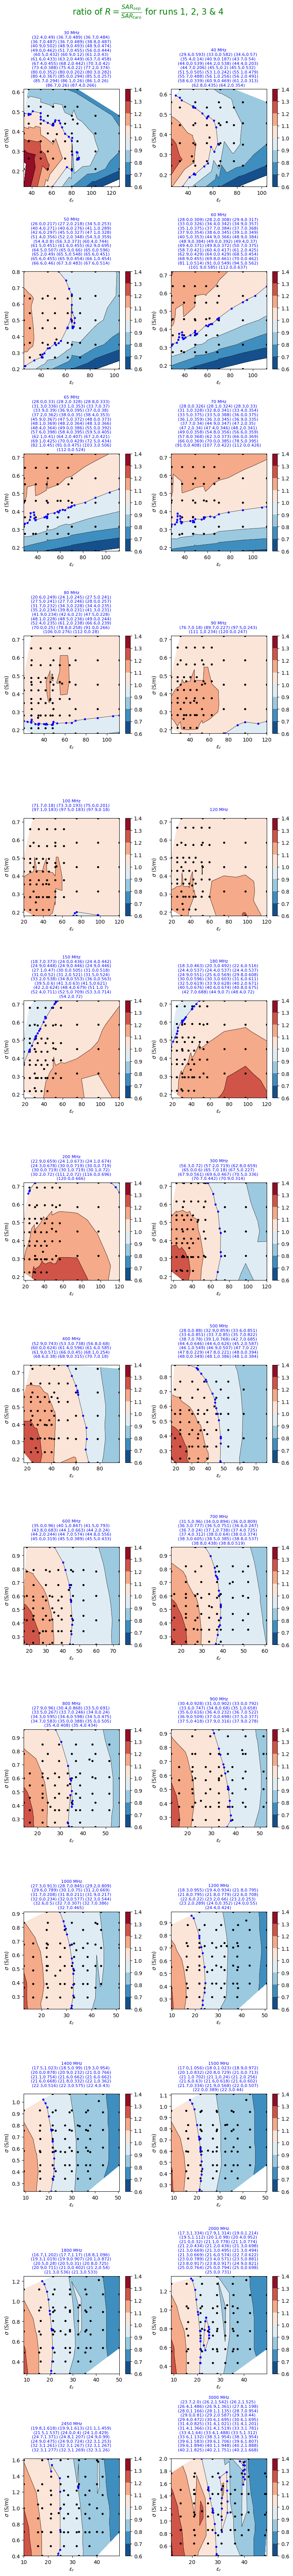

In [320]:
fig, axes = plt.subplots(14,2,figsize=(8,70))
axes = axes.flatten()
levels = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
ixlev1 = levels.index(1)
coords = []

for i, (fMHz, g) in enumerate(dfSAR4c.groupby('fMHz')):
    # draw contour plot for each fMHz
    ax = axes[i]
    CS = ax.tricontour(g.er,g.sigma,g.SARratio,levels=levels,
                       linewidths=0.5, colors='k')
    cntr2 = ax.tricontourf(g.er,g.sigma,g.SARratio,levels=levels,
                           cmap="RdBu_r")
    fig.colorbar(cntr2, ax=ax)
    ax.plot(g.er, g.sigma, 'ko', ms=3)
    ax.set_title(f'{fMHz:g} MHz')
    ax.set(xlabel=r'$\epsilon_r$',ylabel=r'$\sigma$ (S/m)')
    
    # Calculate and print the er/sigma coordinates for R=1
    coord = [[fMHz]+c for path in CS.collections[ixlev1].get_paths() for c in path.vertices.tolist()]
    coords = coords + coord
    coorddf = pd.DataFrame(coord, columns=['fMHz','er','sigma']).sort_values('er').reset_index()

    # Plot those R=1 coordinate points
    axes[i].plot(coorddf.er,coorddf.sigma,'bo',markersize=3)

    # list the R=1 coordinates in the title
    coordpairs = ''
    for ix, c in coorddf.iterrows():
        coordpairs += f'({round(c.er,1)},{round(c.sigma,3)}) '
        if (ix+1) % 3 == 0:
            coordpairs += '\n'
    title = f'{fMHz:g} MHz\n' + coordpairs
    ax.set_title(title, fontsize=8, color='blue')        

fig.suptitle(r'ratio of $R=\frac{SAR_{sep}}{SAR_{taro}}$ for runs 1, 2, 3 & 4',
             color='green', fontsize=16)
fig.tight_layout(rect=(0,0,1,0.98))
# coordsdf3b = pd.DataFrame(coords, columns=['fMHz','er','sigma'])
# fig.savefig('../plots/R contours run 2b & 3',dpi=300)

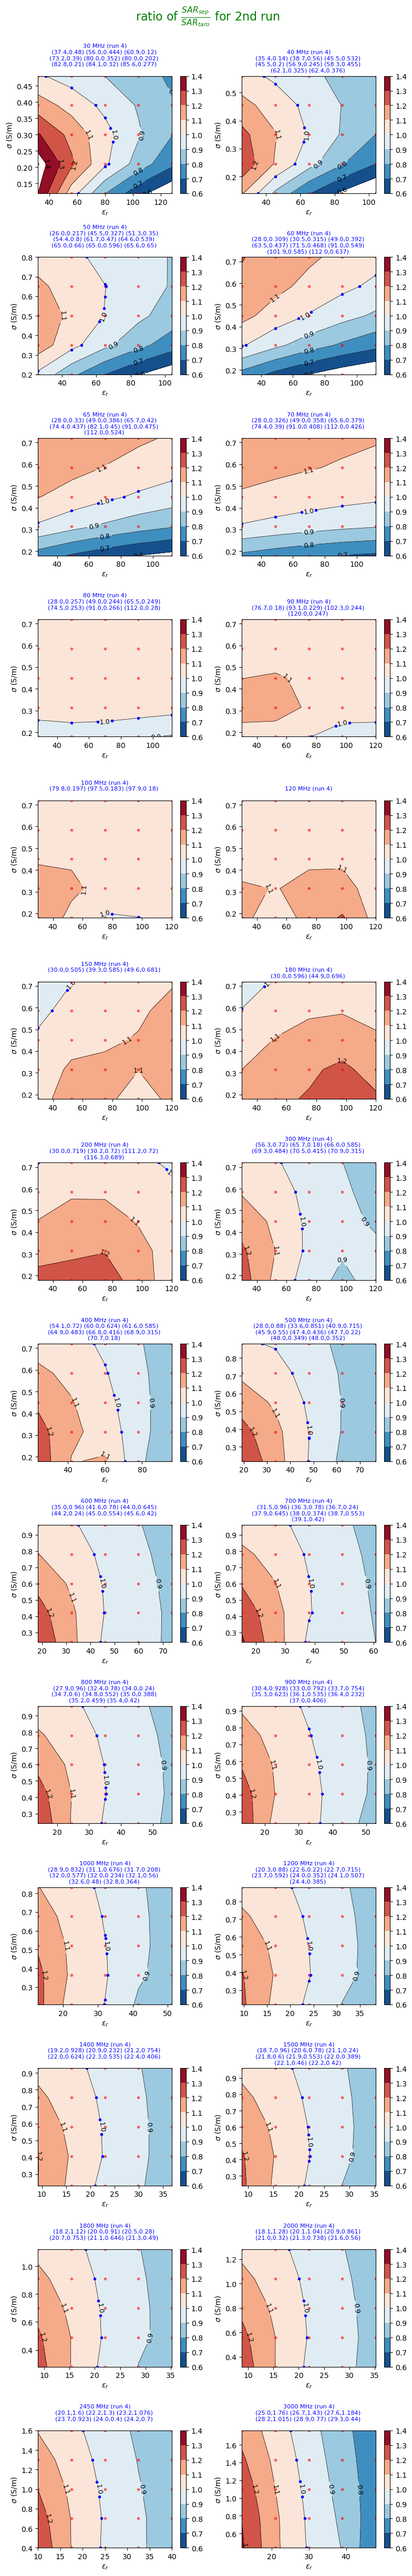

In [316]:
fig, axes = plt.subplots(14,2,figsize=(8,50)) #,sharex=True,sharey=True)
axes = axes.flatten()
levels = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
ixlev1 = levels.index(1)
coords = []

for i, ((fMHz,run), g) in enumerate(dfSAR4.groupby(['fMHz','run'])):
    # draw contour plot for each fMHz
    er = g.er.values.reshape(5,5)
    sigma = g.sigma.values.reshape(5,5)
    SARratio = g.SARratio.values.reshape(5,5)
    CS = axes[i].contour(er,sigma,SARratio,levels=levels,
                         linewidths=0.5,colors='black')
    axes[i].clabel(CS, inline=True, fontsize=9)
    cntr2 = axes[i].contourf(er,sigma,SARratio,levels=levels,
                cmap="RdBu_r")
    fig.colorbar(cntr2, ax=axes[i])
    axes[i].plot(er,sigma,'ro',ms=3,alpha=0.5)
    axes[i].set(xlabel=r'$\epsilon_r$',ylabel=r'$\sigma$ (S/m)')

    # Calculate and print the er/sigma coordinates for R=1
    coord = [[fMHz]+c for path in CS.collections[ixlev1].get_paths() for c in path.vertices.tolist()]
    coords = coords + coord
    coorddf = pd.DataFrame(coord, columns=['fMHz','er','sigma']).sort_values('er').reset_index()

    # Plot those R=1 coordinate points
    axes[i].plot(coorddf.er,coorddf.sigma,'bo',markersize=3)

    # list the R=1 coordinates in the title
    coordpairs = ''
    for ix, c in coorddf.iterrows():
        coordpairs += f'({round(c.er,1)},{round(c.sigma,3)}) '
        if (ix+1) % 3 == 0:
            coordpairs += '\n'
    title = f'{fMHz:g} MHz (run {run})\n' + coordpairs
    axes[i].set_title(title, fontsize=8, color='blue')        

fig.suptitle(r'ratio of $\frac{SAR_{sep}}{SAR_{taro}}$ for 2nd run',
             color='green', fontsize=16)
fig.tight_layout(rect=(0,0,1,0.98))
coordsdf3b = pd.DataFrame(coords, columns=['fMHz','er','sigma'])
fig.savefig('../plots/R contours run 2b & 3',dpi=300)

## Scratch

### Get coordinates of contours

item #0: level=0.5


x         y         r
0   -0.403591 -0.294880  0.499840
1   -0.417534 -0.275000  0.499960
2   -0.425000 -0.263177  0.499887
3   -0.432974 -0.250000  0.499967
4   -0.446497 -0.225000  0.499984
..        ...       ...       ...
137 -0.025000 -0.499375  0.500000
138 -0.050000 -0.497493  0.499999
139 -0.075000 -0.494340  0.499997
140 -0.100000 -0.489892  0.499994
141 -0.111778 -0.487170  0.499828

[142 rows x 3 columns]

item #1: level=1


x         y         r
0    0.855622  0.517413  0.999902
1    0.866004  0.500000  0.999982
2    0.875000  0.484009  0.999945
3    0.879973  0.475000  0.999989
4    0.893014  0.450000  0.999987
..        ...       ...       ...
296  0.565042  0.825000  0.999949
297  0.575000  0.818128  0.999979
298  0.600000  0.800000  1.000000
299  0.600000  0.800000  1.000000
300  0.620496  0.784093  0.999909

[301 rows x 3 columns]

item #2: level=2


x         y         r
0   -1.065814e-14 -2.000000  2.000000
1   -2.500000e-02 -1.999844  2.000000
2   -5.000000e-02 -1.999375  2.000000
3   -7.500000e-02 -1.998593  2.000000
4   -1.000000e-01 -1.997498  2.000000
..            ...       ...       ...
97  -1.618435e+00 -1.175000  1.999990
98  -1.625000e+00 -1.165881  1.999976
99  -1.636291e+00 -1.150000  1.999987
100 -1.650000e+00 -1.130234  1.999982
101 -1.652181e+00 -1.127051  1.999987

[102 rows x 3 columns]

x         y         r
0   -1.826333 -0.815085  1.999964
1   -1.833024 -0.800000  1.999995
2   -1.843735 -0.775000  1.999996
3   -1.850000 -0.759850  1.999968
4   -1.854046 -0.750000  1.999997
..        ...       ...       ...
181 -0.400000  1.959590  1.999999
182 -0.375000  1.964528  1.999999
183 -0.350000  1.969136  1.999999
184 -0.325000  1.973417  2.000000
185 -0.315006  1.975000  1.999963

[186 rows x 3 columns]

x         y         r
0    0.315006  1.975000  1.999963
1    0.325000  1.973417  2.000000
2    0.350000  1.969136  1.999999
3    0.375000  1.964528  1.999999
4    0.400000  1.959590  1.999999
..        ...       ...       ...
232  1.350691 -1.475000  1.999998
233  1.350000 -1.475633  1.999998
234  1.325000 -1.498117  1.999995
235  1.322865 -1.500000  1.999993
236  1.306125 -1.514535  1.999945

[237 rows x 3 columns]

x         y         r
0   1.016379e+00 -1.722450  1.999965
1   1.012057e+00 -1.725000  1.999971
2   1.000000e+00 -1.732042  1.999992
3   9.750000e-01 -1.746240  1.999995
4   9.681968e-01 -1.750000  1.999976
5   9.500000e-01 -1.759962  1.999992
6   9.250000e-01 -1.773236  1.999998
7   9.215838e-01 -1.775000  1.999985
8   9.000000e-01 -1.786048  1.999992
9   8.750000e-01 -1.798435  1.999998
10  8.717468e-01 -1.800000  1.999986
11  8.500000e-01 -1.810379  1.999993
12  8.250000e-01 -1.821912  1.999997
13  8.180896e-01 -1.825000  1.999974
14  8.000000e-01 -1.833024  1.999995
15  7.750000e-01 -1.843735  1.999996
16  7.598503e-01 -1.850000  1.999968
17  7.500000e-01 -1.854046  1.999997
18  7.250000e-01 -1.863962  1.999995
19  7.000000e-01 -1.873498  1.999999
20  6.959165e-01 -1.875000  1.999981
21  6.750000e-01 -1.882647  1.999996
22  6.500000e-01 -1.891424  1.999996
23  6.250000e-01 -1.899835  2.000000
24  6.244908e-01 -1.900000  1.999997
25  6.000000e-01 -1.907875  1.999997
26  5.750000e-01 -1.915558  1.999997
27  5.500000e-01 -1.922887  1.999999
28  5.424507e-01 -1.925000  1.999969
29  5.250000e-01 -1.929862  1.999998
30  5.000000e-01 -1.936489  1.999998
31  4.750000e-01 -1.942773  1.999998
32  4.500000e-01 -1.948717  2.000000
33  4.442917e-01 -1.950000  1.999974
34  4.250000e-01 -1.954321  1.999999
35  4.000000e-01 -1.959590  1.999999
36  3.750000e-01 -1.964528  1.999999
37  3.500000e-01 -1.969136  1.999999
38  3.250000e-01 -1.973417  2.000000
39  3.150059e-01 -1.975000  1.999963
40  3.000000e-01 -1.977372  2.000000
41  2.750000e-01 -1.981003  1.999999
42  2.500000e-01 -1.984313  1.999999
43  2.250000e-01 -1.987303  2.000000
44  2.000000e-01 -1.989974  2.000000
45  1.750000e-01 -1.992329  2.000000
46  1.500000e-01 -1.994367  2.000000
47  1.250000e-01 -1.996090  2.000000
48  1.000000e-01 -1.997498  2.000000
49  7.500000e-02 -1.998593  2.000000
50  5.000000e-02 -1.999375  2.000000
51  2.500000e-02 -1.999844  2.000000
52 -1.065814e-14 -2.000000  2.000000

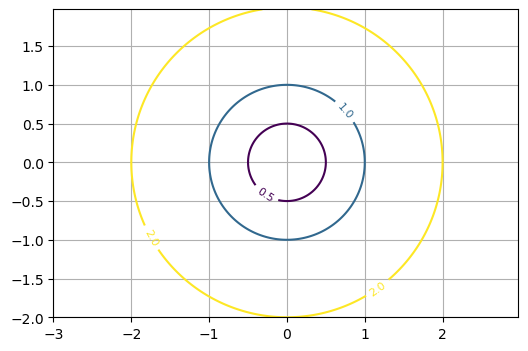

In [246]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

# Made up data for testing plots
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta) 
X, Y = np.meshgrid(x, y)
Z1 = np.sqrt(X**2 + Y**2)
Z2 = 2 * np.sqrt(X**2 + Y**2)

# Create figure
fig1, ax1 = plt.subplots(figsize=[6,4])

# Basic contour plots for two sets of data
levels = [0.5, 1,2]
CS1 = ax1.contour(X, Y, Z1, levels=levels)
ax1.grid()

# Label every other level using strings
# fmt1 = {levels:'S'}
ax1.clabel(CS1, CS1.levels, inline=True, fontsize=8)

for i, item in enumerate(CS1.collections):
    print(f'item #{i}: level={levels[i]}')
    for path in item.get_paths():
        v = path.vertices
        x = v[:, 0]
        y = v[:, 1]
        df = pd.DataFrame(dict(x=x,y=y))
        df['r'] = np.sqrt(df.x**2 + df.y**2)
        display(df)

### Altair scatter chart multi select

In [123]:
import altair as alt
print(f'altair version is: {alt.__version__}')
from vega_datasets import data
cars = data.cars.url

brush = alt.selection_multi()

chart = alt.Chart(cars).mark_point().encode(
    x='Horsepower:Q',
    y='Acceleration:Q',
    color=alt.condition(brush, 'Origin:N', alt.value('lightgray')),
    tooltip=['Horsepower:Q','Acceleration:Q','Displacement:Q']
).add_selection(
    brush
).properties(
    width=250,
    height=250
)

chart | chart.encode(y='Displacement:Q')

altair version is: 4.2.2


alt.HConcatChart(...)

In [256]:
df.fMHz.unique()

array([  30.,   40.,   50.,   60.,   65.,   70.,   80.,  150.,  180.,
        200.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1200.,
       1400., 1500., 1800., 2000., 2450., 3000.])

In [259]:
taroSAR.fMHz.unique()

array([  30,   40,   50,   60,   65,   70,   80,   90,  100,  120,  150,
        180,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1200,
       1400, 1500, 1800, 2000, 2450, 3000], dtype=int64)